## Прогноз цены на драгметаллы в РФ на 2026 год

**Цели исследования:**

   - Разработать модели прогнозирования стоимости драгоценных металлов (золото, серебро, платина, палладий) на 2026 год для граждан РФ.

   - Определить целесообразность инвестиций в драгоценные металлы в 2026 году

**Источник данных:**
   - Официальные котировки Центрального банка Российской Федерации

   - Ежедневные временные ряды цен (руб/г)

**Задачи анализа:**
   - Построить временные ряды для каждого драгметалла

   - Обучить модели Prophet и NeuralProphet с учетом трендов, сезонности и авторегрессии
   
   - Выбрать лучшую модель для каждого драгметалла

   - Сформировать прогнозы на весь 2026 год (300+ дней)
   
   - Дать оценку: стоит ли покупать драгметаллы в 2026 году?

#

**Prophet** - библиотека для прогнозирования временных рядов. Модель автоматически разлагает временной ряд на ключевые компоненты без необходимости ручного выделения.

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$$


- $g(t)$ - тренд (направление, в котором развивается процесс во времени)
- $s(t)$ - сезонность (периодические колебания)
- $h(t)$ - праздничные дни, выходные
- $\epsilon_{t}$ - погрешность

Модель устойчива к пропускам, выбросам и нерегулярным наблюдениям, поэтому ручная очистка или декомпозиция часто не нужна.

## Загрузим данные


In [1]:
#!pip install prophet

In [123]:
import pandas as pd
from pandas.api.types import CategoricalDtype # этот класс позволяет явно задавать категории и порядок 
# их следования, что полезно для статистического анализа и оптимизации памяти
from prophet import Prophet

import requests # инструмент для выполнения HTTP-запросов к веб-сервисам и сайтам

'''
библиотека для парсинга (разбора) HTML и XML документов. Она преобразует исходный код веб-страницы в 
дерево объектов, которое удобно анализировать, находить нужные элементы, извлекать данные и изменять структуру.
'''
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns 

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings; 
warnings.filterwarnings('ignore')

In [124]:
URL = 'https://www.cbr.ru/hd_base/metall/metall_base_new/?UniDbQuery.Posted=True\
&UniDbQuery.From=01.07.2008&UniDbQuery.To=27.12.2025&UniDbQuery.Gold=true&UniDbQuery.Silver=true&UniDbQuery.Platinum=true&UniDbQuery.Palladium=true&UniDbQuery.so=1'

data = requests.get(URL).text # считываем в виде текста то что по ссылке находится
#print(data)

# создает объект BeautifulSoup для удобного парсинга HTML кода страницы, используя встроенный парсер Python
beautiful_soup = BeautifulSoup(data, "html.parser")
tables = beautiful_soup.find_all("table") # находит все HTML-теги <table> на странице — таблицы, которые могут 
# содержать нужные данные
'''
читает HTML таблицы из строкового представления найденных таблиц и берет первую из них в DataFrame df
'''
df = pd.read_html(str(tables), 
                  thousands=' ',      # пробел как разделитель тысяч
                  decimal=',')[0]    # запятая как десятичный разделитель

df['Золото'] = pd.to_numeric(df['Золото'], errors='coerce')  # Все не-числа → NaN
df['Серебро'] = pd.to_numeric(df['Серебро'], errors='coerce')
df['Платина'] = pd.to_numeric(df['Платина'], errors='coerce')
df['Палладий'] = pd.to_numeric(df['Палладий'], errors='coerce')
"""
Заполняем пропуски во 2-ом столбце средним, т.к. в конечном итоге хотим получить среднюю оценку в качестве прогноза
"""
df['Золото'] = df['Золото'].fillna(df['Золото'].mean())     # NaN → среднее
df['Серебро'] = df['Серебро'].fillna(df['Серебро'].mean())     
df['Платина'] = df['Платина'].fillna(df['Платина'].mean())     
df['Палладий'] = df['Палладий'].fillna(df['Палладий'].mean())     

df

,Дата* ▼,Золото,Серебро,Платина,Палладий
0,27.12.2025,11192.43,174.20,5515.28,4588.58
1,26.12.2025,11220.10,174.63,5528.92,4599.92
2,25.12.2025,11220.50,175.87,5568.13,4632.55
3,24.12.2025,11171.58,174.89,5262.83,4479.60
4,23.12.2025,11060.97,167.75,4987.84,4291.69
...,...,...,...,...,...
4327,08.07.2008,697.60,13.64,1504.27,342.36
4328,05.07.2008,703.59,13.84,1528.52,344.71
4329,04.07.2008,706.27,13.47,1551.20,351.73
4330,03.07.2008,704.62,13.22,1562.06,352.31


In [125]:
df.columns = ['Дата', 'Золото', 'Серебро', 'Платина', 'Палладий']
'''
преобразует столбец "Дата" из строкового формата в тип данных datetime pandas с указанием формата даты "день.месяц.год". 
Это позволяет pandas правильно понять и работать с датами как с объектами времени.
'''
df['Дата'] = pd.to_datetime(df['Дата'].astype(str), format='%d.%m.%Y')
'''
сортирует DataFrame по возрастанию дат в столбце "Дата" и сбрасывает индексы(чтобы нумеровалось не в кучу, 
а последовательно)
'''
df = df.sort_values(by='Дата').reset_index(drop=True)

df

,Дата,Золото,Серебро,Платина,Палладий
0,2008-07-02,701.35,13.32,1565.67,352.37
1,2008-07-03,704.62,13.22,1562.06,352.31
2,2008-07-04,706.27,13.47,1551.20,351.73
3,2008-07-05,703.59,13.84,1528.52,344.71
4,2008-07-08,697.60,13.64,1504.27,342.36
...,...,...,...,...,...
4327,2025-12-23,11060.97,167.75,4987.84,4291.69
4328,2025-12-24,11171.58,174.89,5262.83,4479.60
4329,2025-12-25,11220.50,175.87,5568.13,4632.55
4330,2025-12-26,11220.10,174.63,5528.92,4599.92


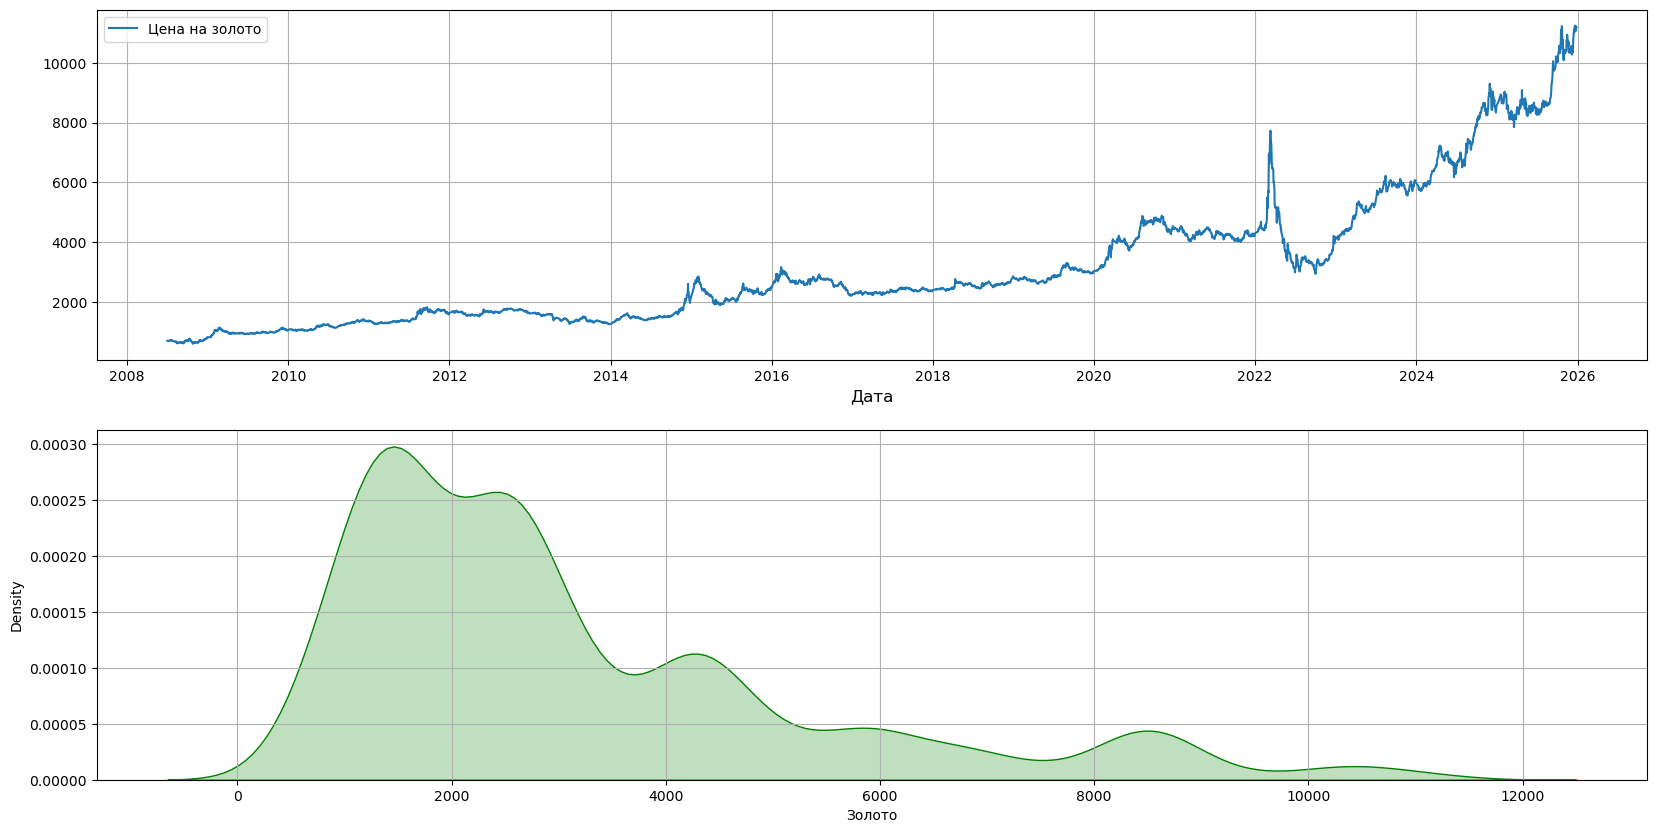

In [126]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].plot(df['Дата'], df['Золото'], label='Цена на золото') 
axes[0].set_xlabel('Дата', fontsize=12)
axes[0].legend(loc="best")
axes[0].grid(True) 

'''
строим плотность распределения цены на золото
'''
sns.kdeplot(df['Золото'], ax=axes[1], color='green', fill=True)
axes[1].grid(True)
plt.show()

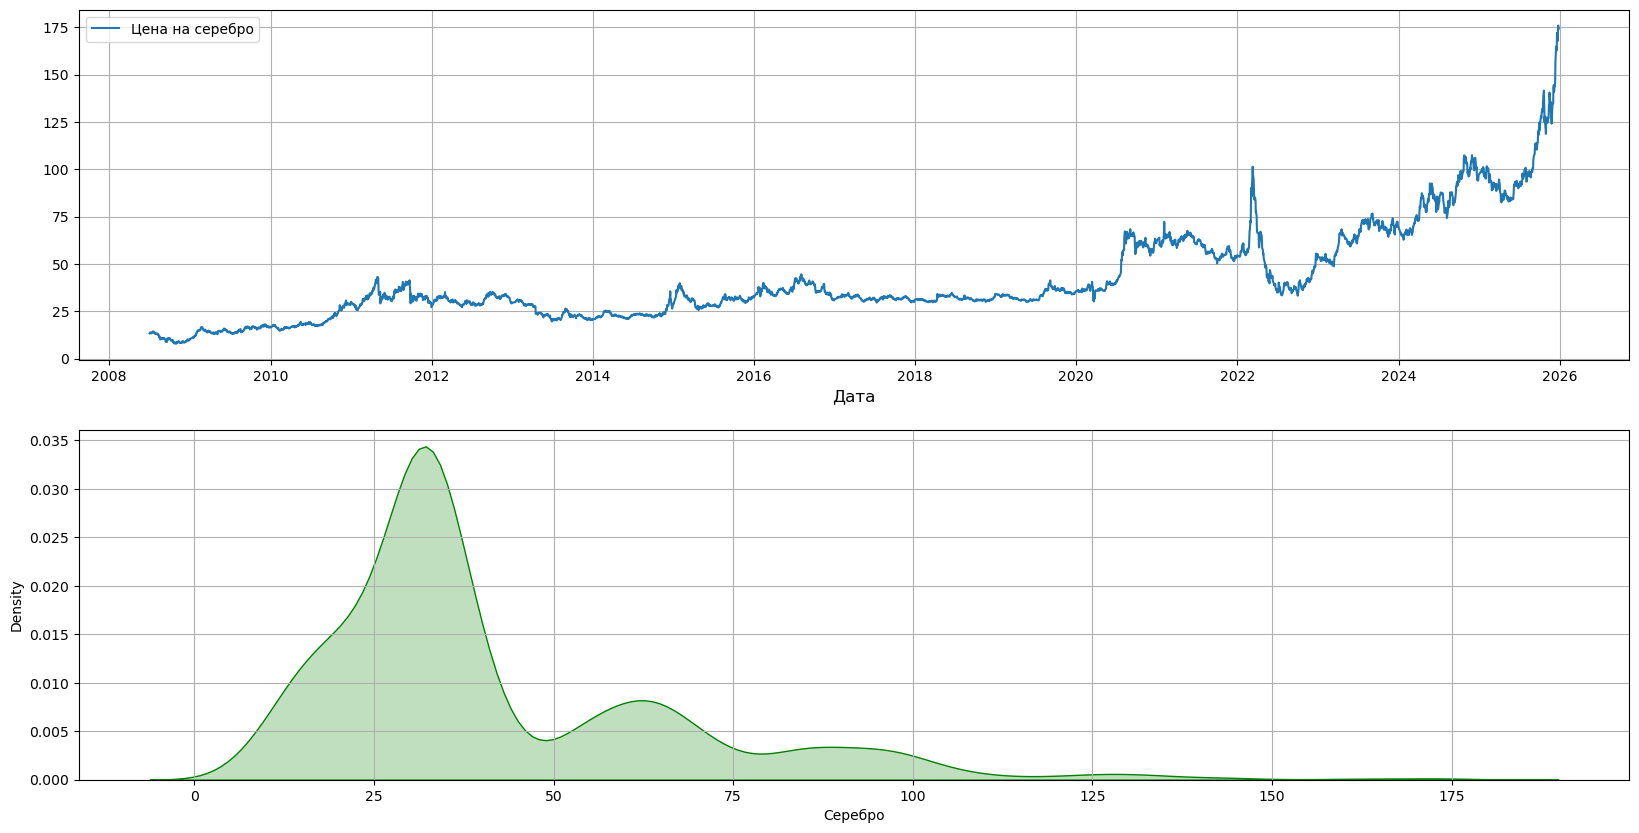

In [127]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].plot(df['Дата'], df['Серебро'], label='Цена на серебро') 
axes[0].set_xlabel('Дата', fontsize=12)
axes[0].legend(loc="best")
axes[0].grid(True) 

sns.kdeplot(df['Серебро'], ax=axes[1], color='green', fill=True)
axes[1].grid(True)
plt.show()

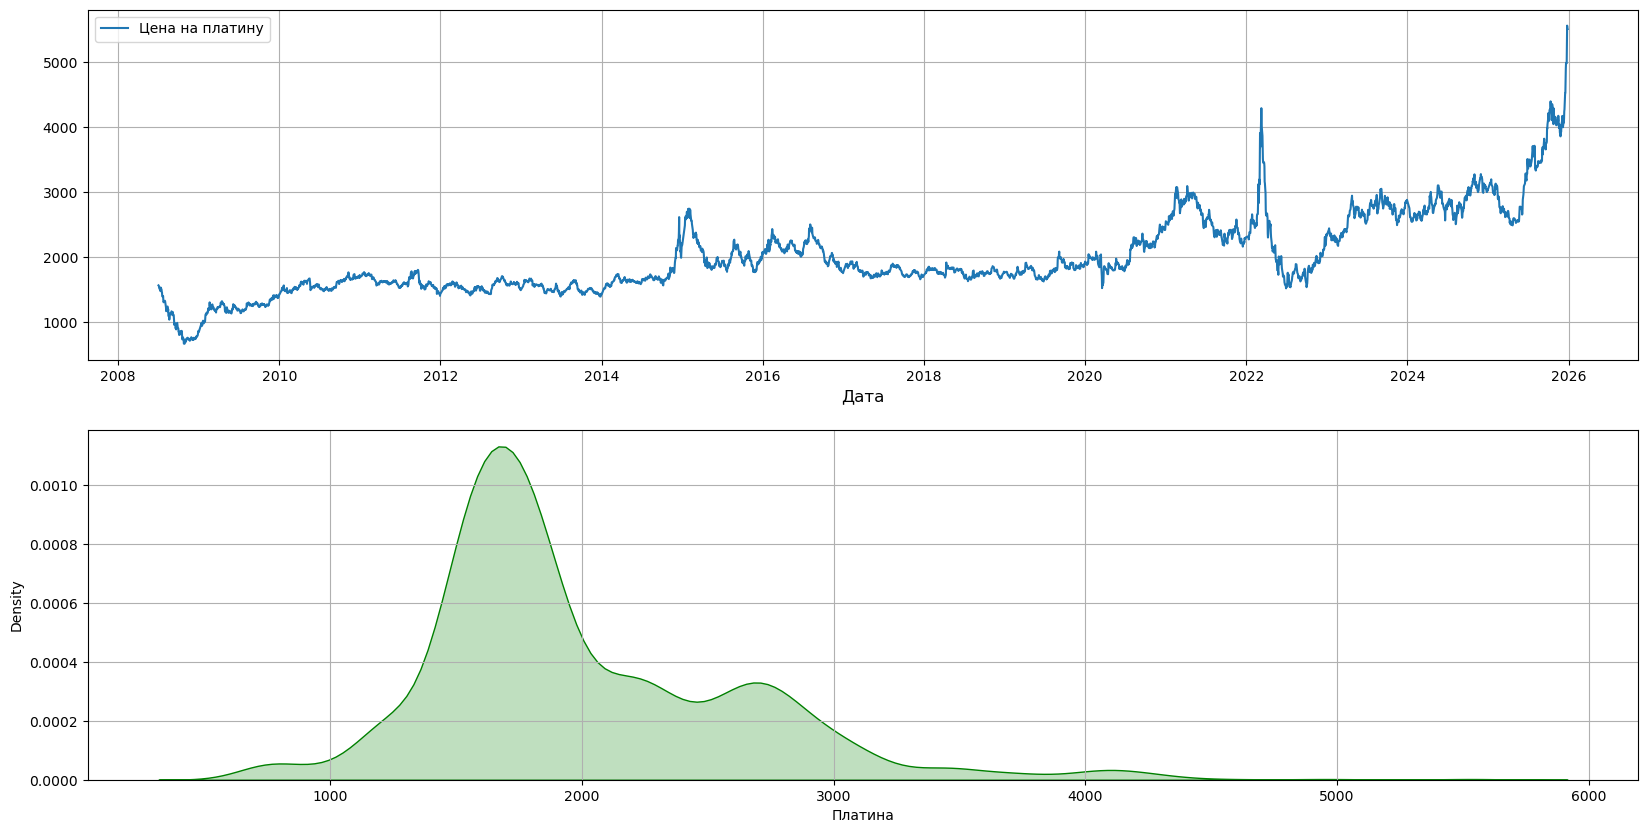

In [128]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].plot(df['Дата'], df['Платина'], label='Цена на платину') 
axes[0].set_xlabel('Дата', fontsize=12)
axes[0].legend(loc="best")
axes[0].grid(True) 

sns.kdeplot(df['Платина'], ax=axes[1], color='green', fill=True)
axes[1].grid(True)
plt.show()

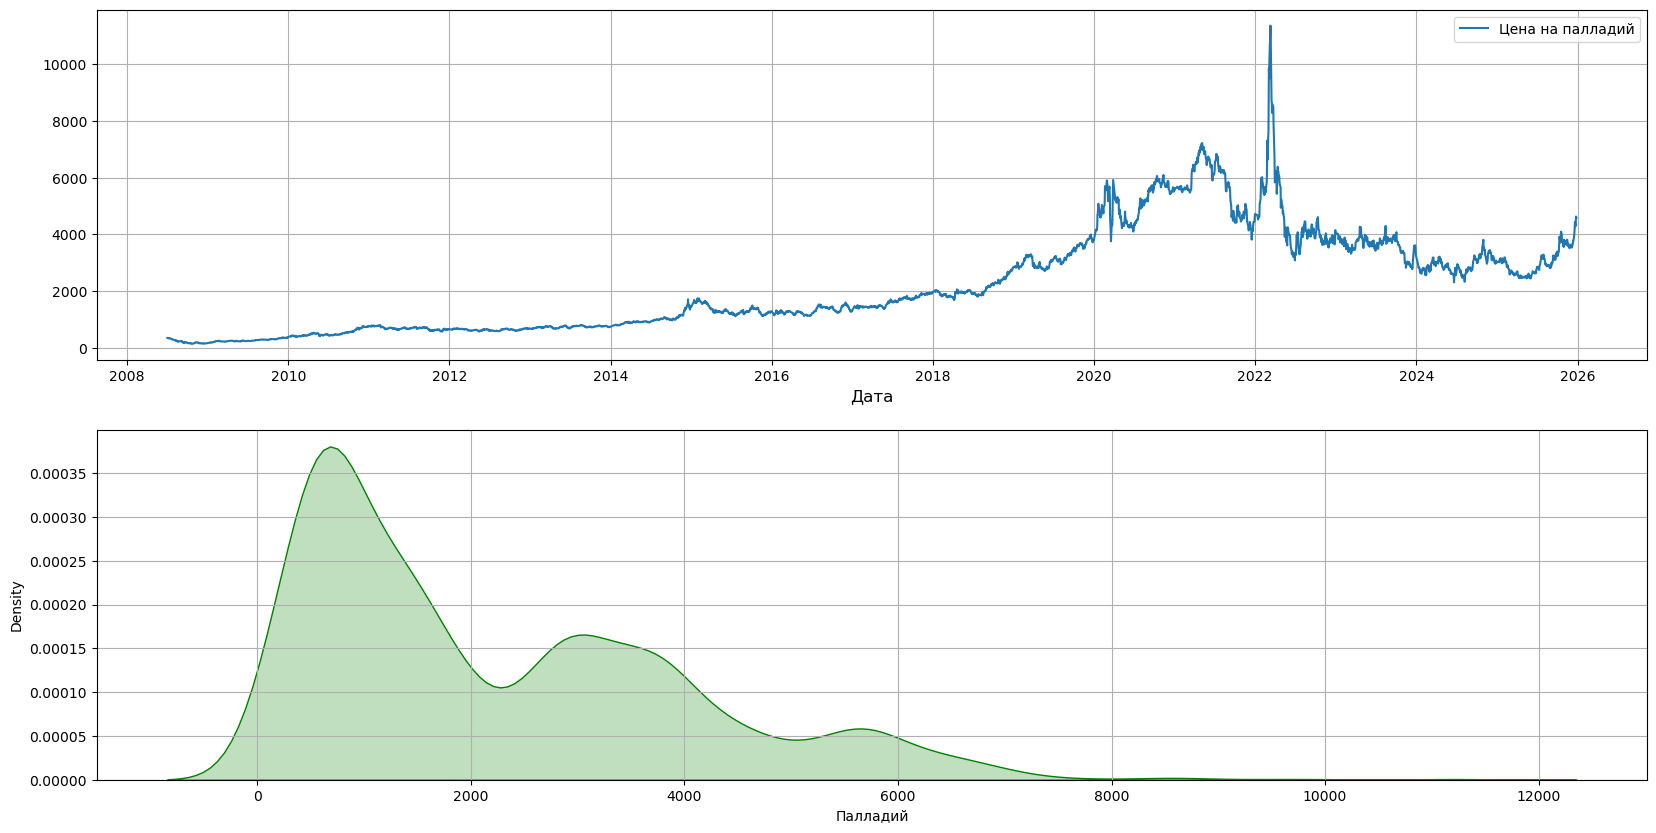

In [129]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].plot(df['Дата'], df['Палладий'], label='Цена на палладий') 
axes[0].set_xlabel('Дата', fontsize=12)
axes[0].legend(loc="best")
axes[0].grid(True) 

sns.kdeplot(df['Палладий'], ax=axes[1], color='green', fill=True)
axes[1].grid(True)
plt.show()

Видим, что данные не являются нормально распределенными. Однако модель Prophet не требует нормального распределения, 
поэтому ничего менять не будем

## Предобработка

Добавим признаков, чтобы понять есть ли еще какие-то зависимости.

In [130]:
def assign_season(month):
    if month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    elif month in [9, 10, 11]:
        return 'Осень'
    else:
        return 'Зима'
    
def rusification(day_of_week):
    if day_of_week == 'Monday':
        day_of_week = 'Понедельник'
    elif day_of_week == 'Tuesday':
        day_of_week = 'Вторник'
    elif day_of_week == 'Wednesday':
        day_of_week = 'Среда'
    elif day_of_week == 'Thursday':
        day_of_week = 'Четверг'
    elif day_of_week == 'Friday':
        day_of_week = 'Пятница'
    elif day_of_week == 'Saturday':
        day_of_week = 'Суббота'
    elif day_of_week == 'Sunday':
        day_of_week = 'Воскресенье'
        
    return day_of_week

def create_features(data_full, col_datetime):
    """Создает объекты временных рядов"""

    data = data_full.copy()
    data['День недели'] = data[col_datetime].dt.day_name()
    data['День недели'] = data['День недели'].apply(rusification).astype(cat_type)
    '''
    Что значит ".astype(cat_type)" на практике:

      1) Значения в столбце преобразуются в один из указанных категориальных вариантов.
      2) Категории имеют порядок, определённый в categories, поэтому можно сортировать или сравнивать их логически 
      (например, "Понедельник" < "Вторник").
      3) Это экономит память при работе с повторяющимися значениями, так как категории хранятся отдельно, 
      а в столбце только ссылки на них.
    '''
    data['Месяц'] = data[col_datetime].dt.month # извлекает месяц
    data['Год'] = data[col_datetime].dt.year # извлекает год
    
    data['Квартал'] = data['Дата'].dt.quarter # метод извлекает квартал года (число от 1 до 4) из даты
    data['Сезон'] = data[col_datetime].dt.month.apply(assign_season)
    
    return data


cat_type = CategoricalDtype(categories=['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота',
    'Воскресенье'], ordered=True)

df_features = create_features(data_full=df, col_datetime='Дата')
df_features

,Дата,Золото,Серебро,Платина,Палладий,День недели,Месяц,Год,Квартал,Сезон
0,2008-07-02,701.35,13.32,1565.67,352.37,Среда,7,2008,3,Лето
1,2008-07-03,704.62,13.22,1562.06,352.31,Четверг,7,2008,3,Лето
2,2008-07-04,706.27,13.47,1551.20,351.73,Пятница,7,2008,3,Лето
3,2008-07-05,703.59,13.84,1528.52,344.71,Суббота,7,2008,3,Лето
4,2008-07-08,697.60,13.64,1504.27,342.36,Вторник,7,2008,3,Лето
...,...,...,...,...,...,...,...,...,...,...
4327,2025-12-23,11060.97,167.75,4987.84,4291.69,Вторник,12,2025,4,Зима
4328,2025-12-24,11171.58,174.89,5262.83,4479.60,Среда,12,2025,4,Зима
4329,2025-12-25,11220.50,175.87,5568.13,4632.55,Четверг,12,2025,4,Зима
4330,2025-12-26,11220.10,174.63,5528.92,4599.92,Пятница,12,2025,4,Зима


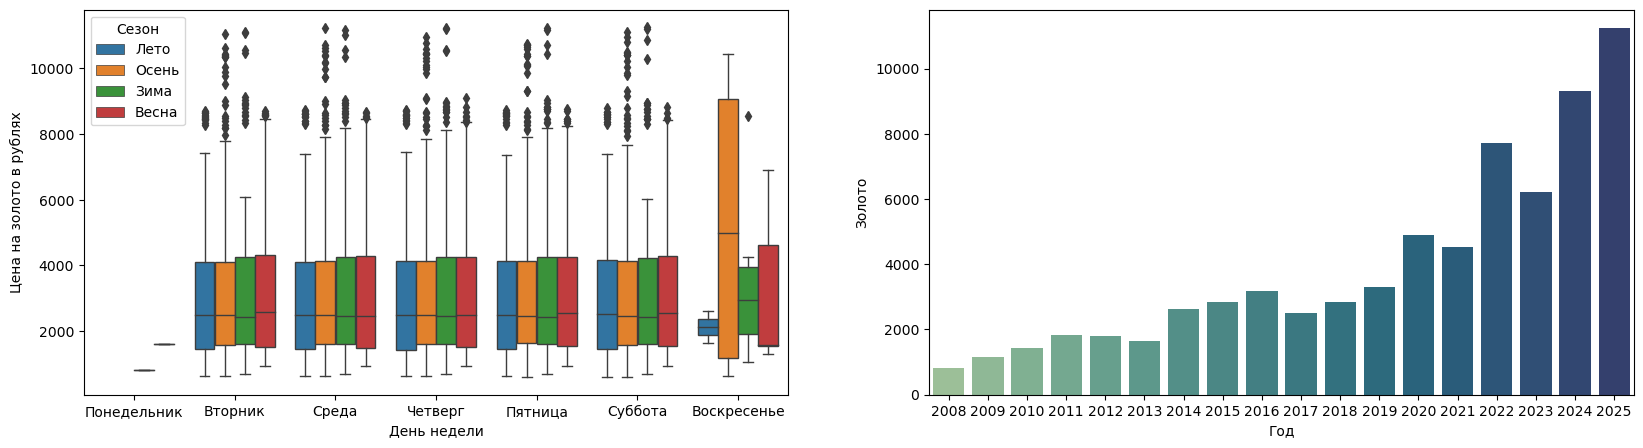

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.boxplot(data=df_features,
            x='День недели',
            y='Золото',
            hue='Сезон',
            ax=axes[0],
            linewidth=1)
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Цена на золото в рублях')

# сортируем по годам и ищем для каждого года максимум, сбрасываем индексы и сортируем по возрастанию цены на золото
yearAggregated = pd.DataFrame(df_features.groupby(
    "Год")["Золото"].max()).reset_index().sort_values('Золото')
sns.barplot(data=yearAggregated, x="Год", y="Золото", palette='crest')
plt.show()

In [132]:
df_features[(df_features['Сезон']=='Осень')&(df_features['День недели']=='Воскресенье')]

,Дата,Золото,Серебро,Платина,Палладий,День недели,Месяц,Год,Квартал,Сезон
89,2008-11-02,636.20,8.08,708.68,172.38,Воскресенье,11,2008,4,Осень
593,2010-11-14,1376.80,26.56,1697.57,697.08,Воскресенье,11,2010,4,Осень
4046,2024-11-03,8606.95,102.87,3148.84,3531.47,Воскресенье,11,2024,4,Осень
4293,2025-11-02,10432.09,127.32,4132.27,3809.80,Воскресенье,11,2025,4,Осень


Видим на левом графике, что понедельник содержит мало информации. Его можно выбросить из рассмотрения.

Видим на правом графике, что цена на золото периодически чуть-чуть падает, но на дистанции становится больше и больше. Уже можно понять, что прогноз на будущее будет - повышение цены.

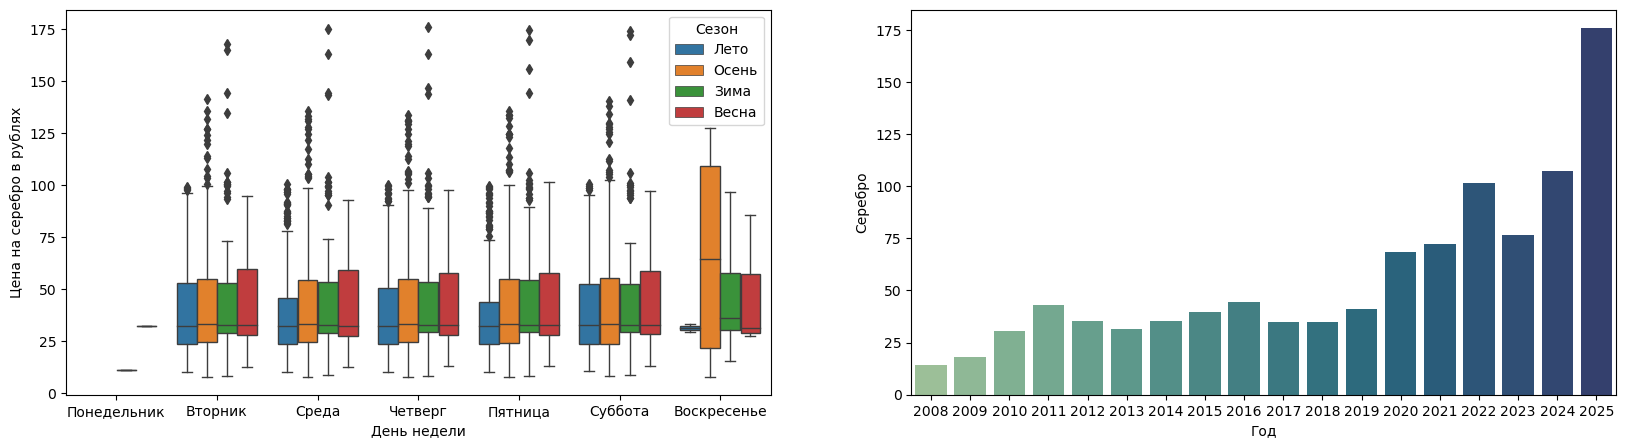

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.boxplot(data=df_features,
            x='День недели',
            y='Серебро',
            hue='Сезон',
            ax=axes[0],
            linewidth=1)
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Цена на серебро в рублях')

yearAggregated = pd.DataFrame(df_features.groupby(
    "Год")["Серебро"].max()).reset_index().sort_values('Серебро')
sns.barplot(data=yearAggregated, x="Год", y="Серебро", palette='crest')
plt.show()

На левом графике, как и для золота, видно, что понедельник можно отбросить.

На правом графике видно, что серебро из года в год растет в цене, а в 2025 году произошел резкий скачок. Также из графика видно, что после скачков происходит небольшое понижение. Так что можно ожидать, что цена в начале года станет ниже, а затем снова начнет расти и в какой-то момент превзойдет последний скачок.  

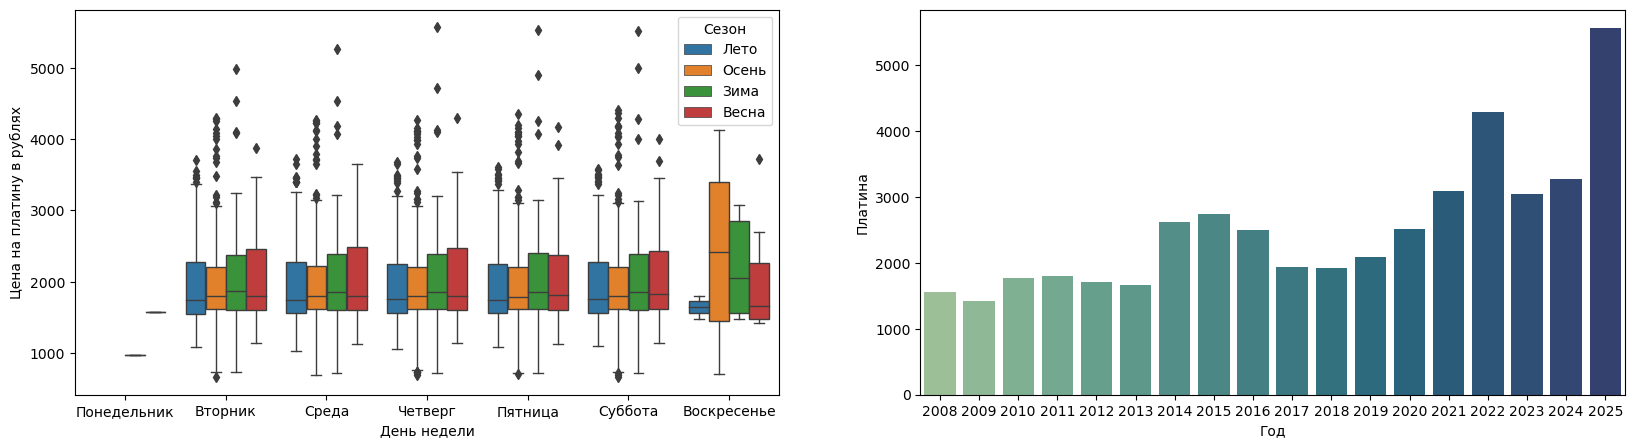

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.boxplot(data=df_features,
            x='День недели',
            y='Платина',
            hue='Сезон',
            ax=axes[0],
            linewidth=1)
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Цена на платину в рублях')

yearAggregated = pd.DataFrame(df_features.groupby(
    "Год")["Платина"].max()).reset_index().sort_values('Платина')
sns.barplot(data=yearAggregated, x="Год", y="Платина", palette='crest')
plt.show()

На графиках все примерно так же, как и для серебра, но с менее бурным ростом.

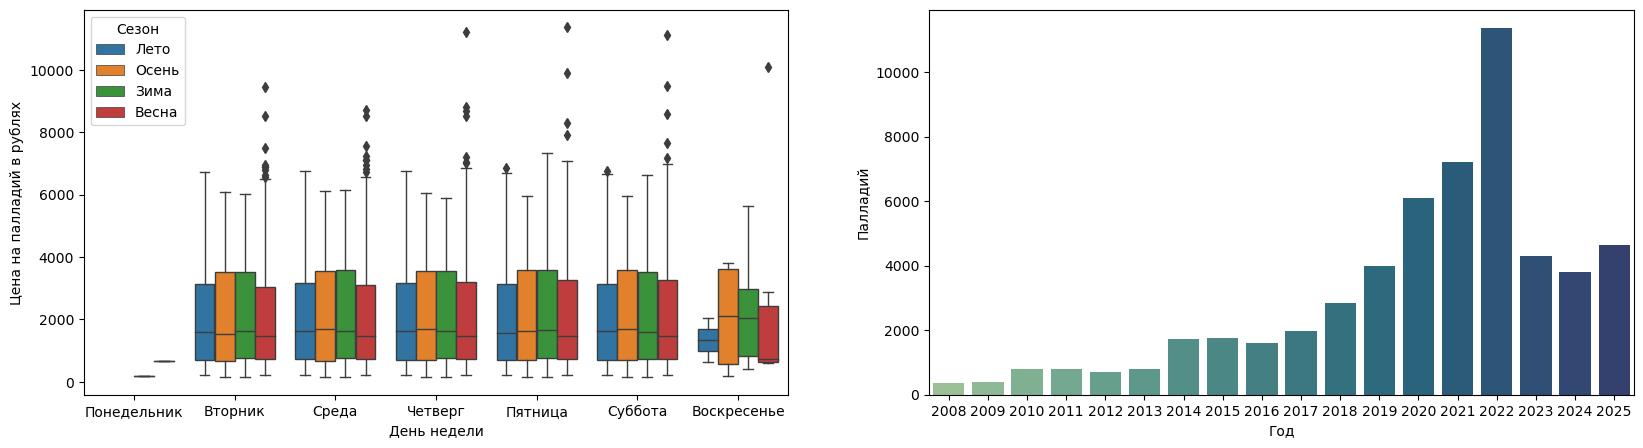

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.boxplot(data=df_features,
            x='День недели',
            y='Палладий',
            hue='Сезон',
            ax=axes[0],
            linewidth=1)
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Цена на палладий в рублях')

yearAggregated = pd.DataFrame(df_features.groupby(
    "Год")["Палладий"].max()).reset_index().sort_values('Палладий')
sns.barplot(data=yearAggregated, x="Год", y="Палладий", palette='crest')
plt.show()

На левом графике все примерно так же, как для других драгметаллов.

На правом графике видно, что до 2022 года палладий сильно рос в цене, а в 2022 произошел резкий скачок вверх, но уже на следующий год цена резко упала и продолжает держаться на средних значениях по сравнению с предыдущими годами. 

Для всех драгметаллов можно убрать понедельник из рассмотрения

In [136]:
df_features[df_features['День недели'] == 'Понедельник']

,Дата,Золото,Серебро,Платина,Палладий,День недели,Месяц,Год,Квартал,Сезон
131,2009-01-12,831.71,11.01,969.88,192.41,Понедельник,1,2009,1,Зима
918,2012-03-12,1602.71,32.17,1571.84,655.33,Понедельник,3,2012,1,Весна


In [137]:
drop_idx = df_features[df_features['День недели'] == 'Понедельник'].index
df = df[~df.index.isin(drop_idx)] # новый датафрейм без понедельника
df = df.reset_index(drop=True) # обновляем индексы

## Модель Prophet

In [138]:
# prophet обязательно требует такие названия!
df_zoloto = df.rename(columns={'Дата': 'ds', 'Золото': 'y'}).drop(['Серебро', 'Платина', 'Палладий'], axis=1) 
df_serebro = df.rename(columns={'Дата': 'ds', 'Серебро': 'y'}).drop(['Золото', 'Платина', 'Палладий'], axis=1) 
df_platina = df.rename(columns={'Дата': 'ds', 'Платина': 'y'}).drop(['Золото', 'Серебро', 'Палладий'], axis=1) 
df_palladiy = df.rename(columns={'Дата': 'ds', 'Палладий': 'y'}).drop(['Золото', 'Серебро', 'Платина'], axis=1) 
SIZE = int(df.shape[0]*0.1)

# так как имеем дело в временными рядами, то в качестве тестовых данных берем правую часть
train_df_zoloto = df_zoloto[:-SIZE]
test_df_zoloto = df_zoloto[-SIZE:]
train_df_serebro = df_serebro[:-SIZE]
test_df_serebro = df_serebro[-SIZE:]
train_df_platina = df_platina[:-SIZE]
test_df_platina = df_platina[-SIZE:]
train_df_palladiy = df_palladiy[:-SIZE]
test_df_palladiy = df_palladiy[-SIZE:]

print(train_df_zoloto.shape)
print(test_df_zoloto.shape)

(3897, 2)
(433, 2)


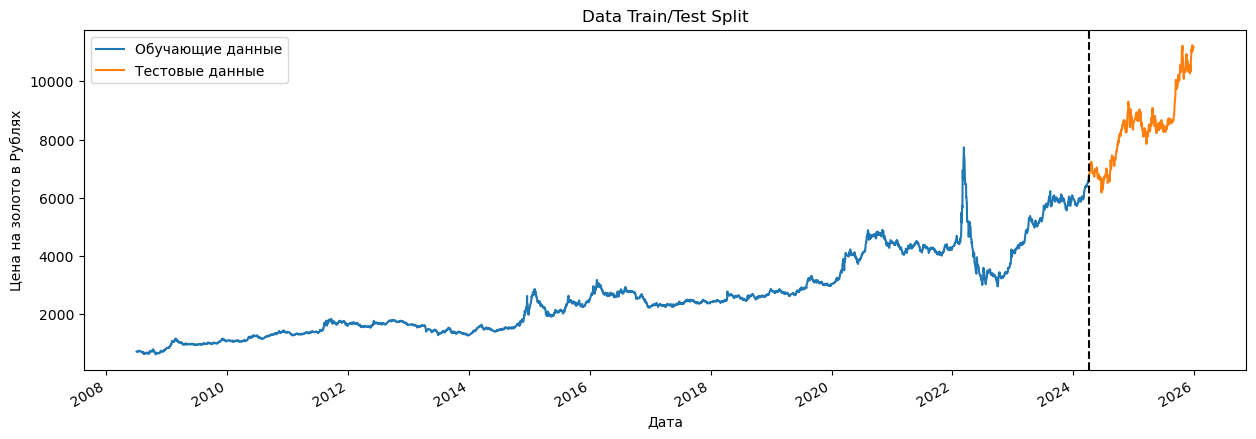

In [139]:
fig, ax = plt.subplots(figsize=(15, 5))

train_df_zoloto.set_index('ds').plot(ax=ax,
                              label='Train',
                              title='Data Train/Test Split')
test_df_zoloto.set_index('ds').plot(ax=ax, label='Test')
ax.axvline(train_df_zoloto['ds'][-1:].values, color='black', ls='--')
ax.legend(['Обучающие данные', 'Тестовые данные'])
ax.set_ylabel('Цена на золото в Рублях')
ax.set_xlabel('Дата')
plt.show()

In [142]:
%%time 
# changepoint_prior_scale - более высокие значение позволят иметь больше точек излома
model1 = Prophet(changepoint_prior_scale=0.3)
model1.fit(train_df_zoloto)

model2 = Prophet(changepoint_prior_scale=0.3)
model2.fit(train_df_serebro)

model3 = Prophet(changepoint_prior_scale=0.3)
model3.fit(train_df_platina)

model4 = Prophet(changepoint_prior_scale=0.3)
model4.fit(train_df_palladiy)

04:55:02 - cmdstanpy - INFO - Chain [1] start processing
04:55:04 - cmdstanpy - INFO - Chain [1] done processing
04:55:04 - cmdstanpy - INFO - Chain [1] start processing
04:55:06 - cmdstanpy - INFO - Chain [1] done processing
04:55:06 - cmdstanpy - INFO - Chain [1] start processing
04:55:08 - cmdstanpy - INFO - Chain [1] done processing
04:55:09 - cmdstanpy - INFO - Chain [1] start processing
04:55:10 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 1.12 s
Wall time: 8.63 s


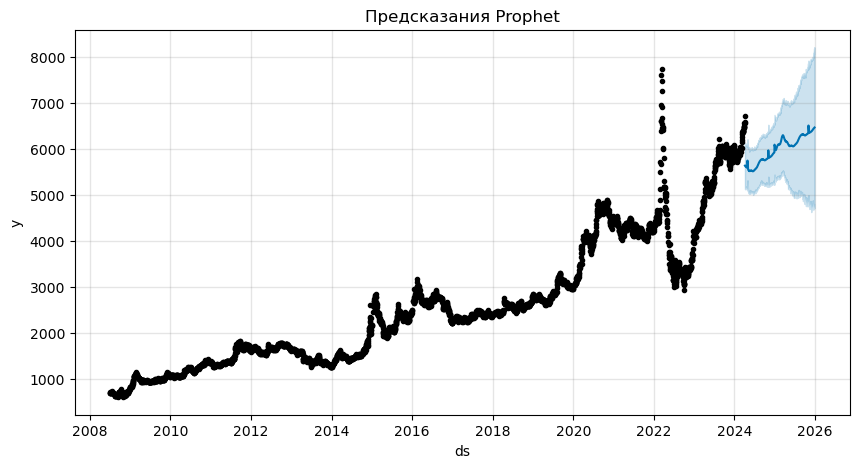

In [143]:
fig, ax = plt.subplots(figsize=(10, 5))

predict1 = model1.predict(test_df_zoloto)
model1.plot(predict1, ax=ax)
ax.set_title('Предсказания Prophet')
plt.show()

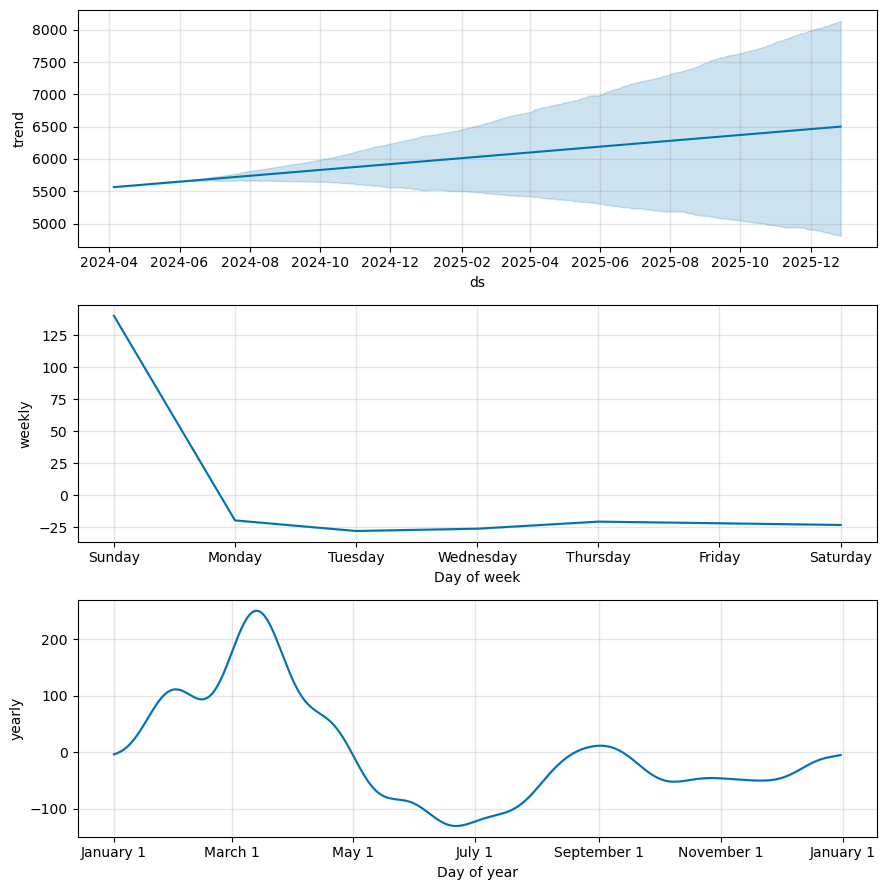

In [144]:
# разложение на компоненты (тренд, сезонность(еженедельная, ежегодная))
fig = model1.plot_components(predict1)
plt.show()

Из 1-го графика видно, что тренд монотонно растет. 

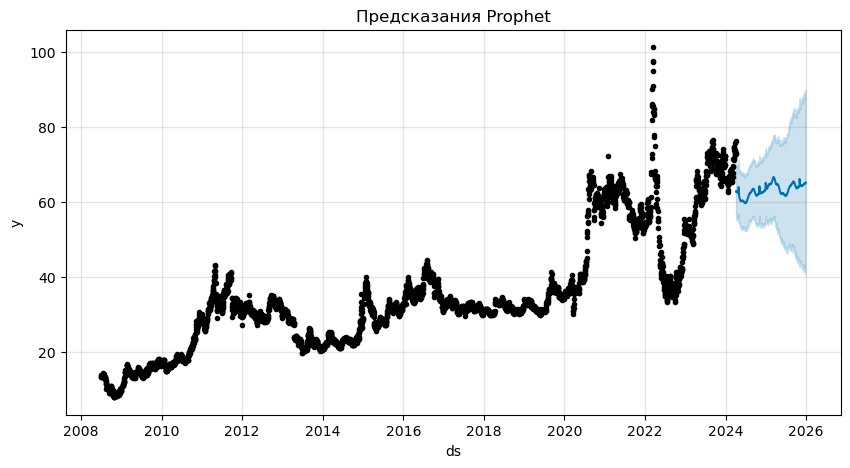

In [145]:
fig, ax = plt.subplots(figsize=(10, 5))

predict2 = model2.predict(test_df_serebro)
fig = model2.plot(predict2, ax=ax)
ax.set_title('Предсказания Prophet')
plt.show()

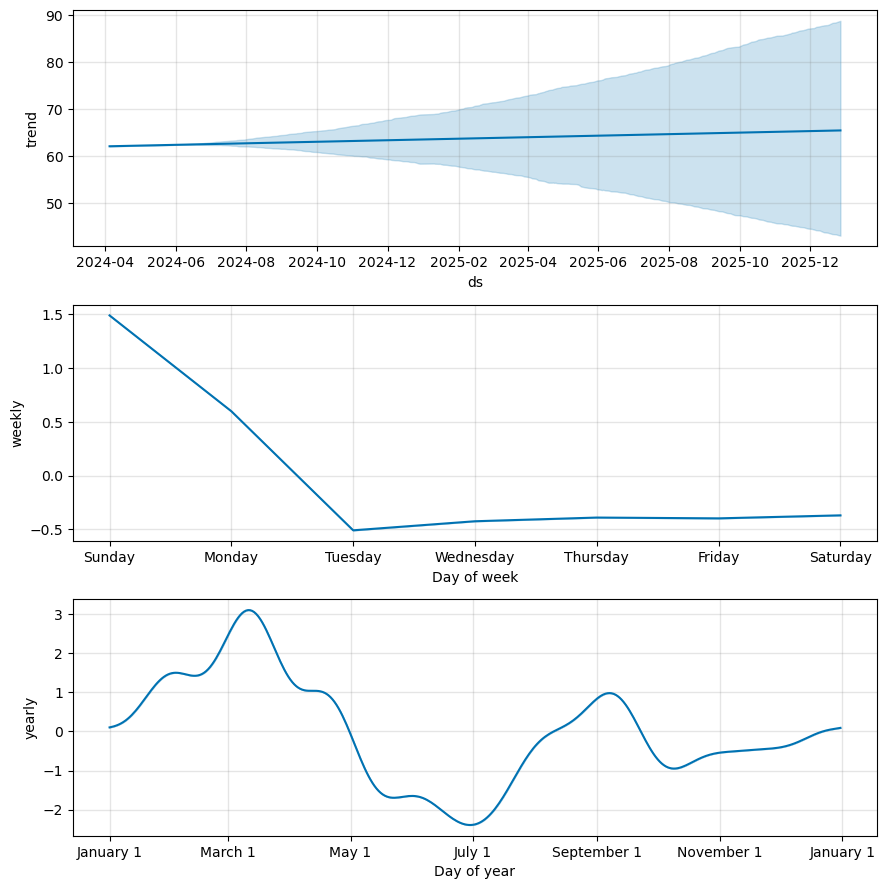

In [146]:
fig = model2.plot_components(predict2)
plt.show()

Все примерно так же, как у золота

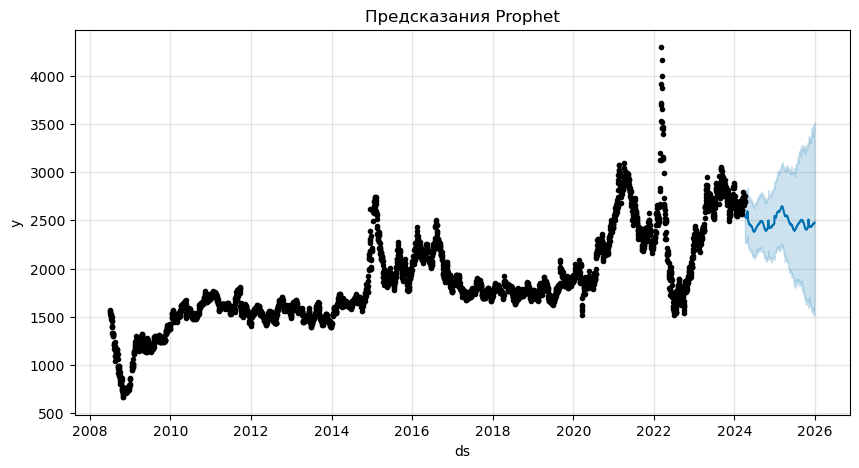

In [147]:
fig, ax = plt.subplots(figsize=(10, 5))

predict3 = model3.predict(test_df_platina)
fig = model3.plot(predict3, ax=ax)
ax.set_title('Предсказания Prophet')
plt.show()

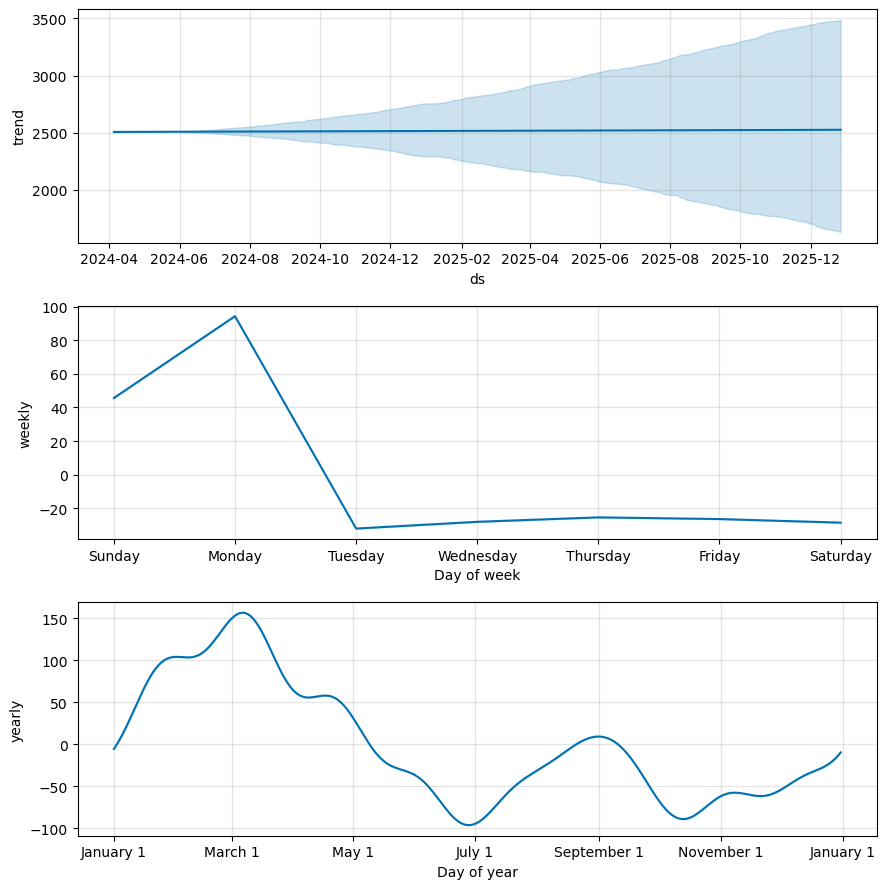

In [148]:
fig = model3.plot_components(predict3)
plt.show()

Видим тренд на то, что цена платины всегда примерно одинакова, однако имеют место сезонные сдвиги.

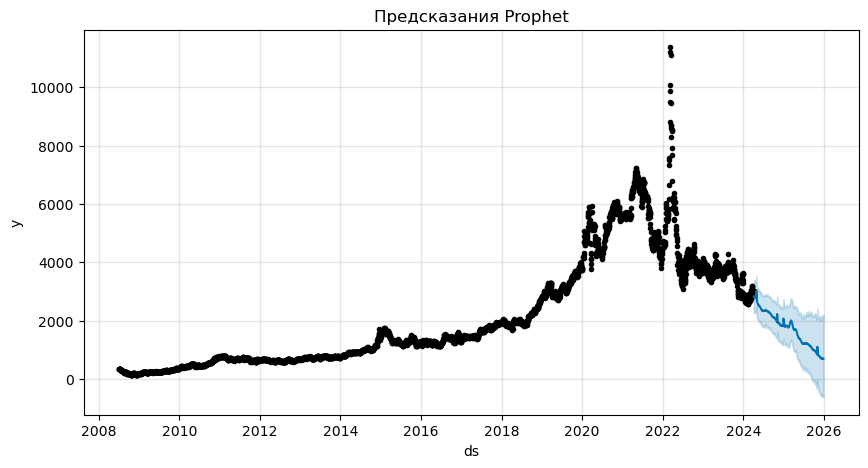

In [150]:
fig, ax = plt.subplots(figsize=(10, 5))

predict4 = model4.predict(test_df_palladiy)
fig = model4.plot(predict4, ax=ax)
ax.set_title('Предсказания Prophet')
plt.show()

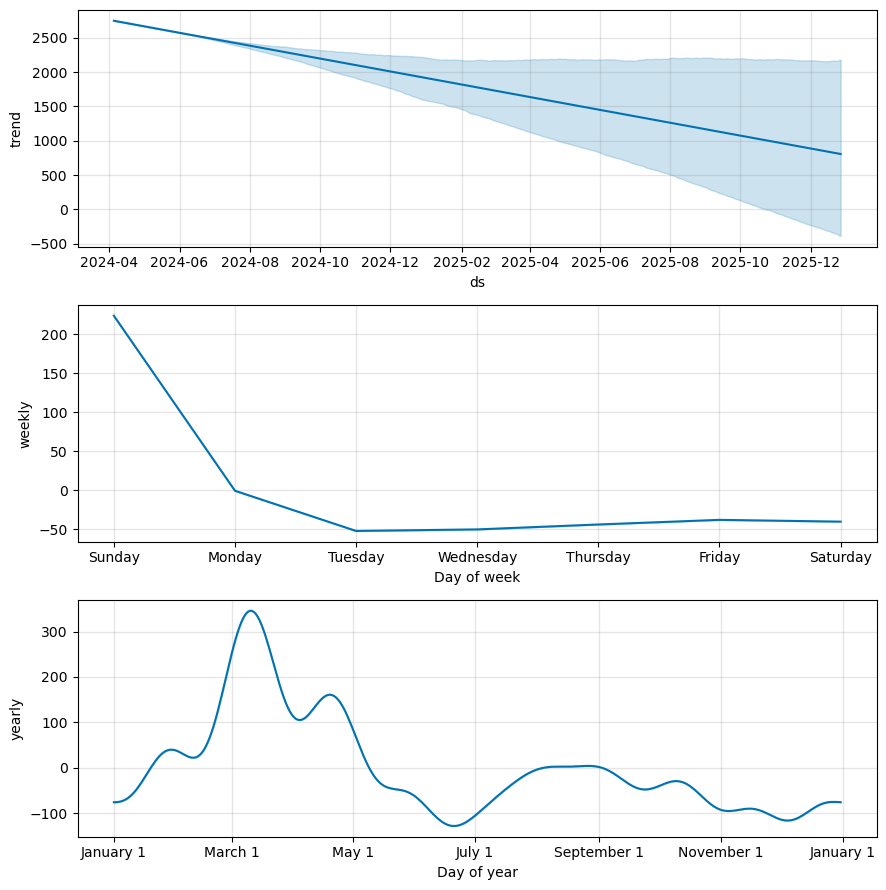

In [152]:
fig = model4.plot_components(predict4)
plt.show()

У палладия видим тренд на снижение цены. По сезонности все так же, как у других драгметаллов.

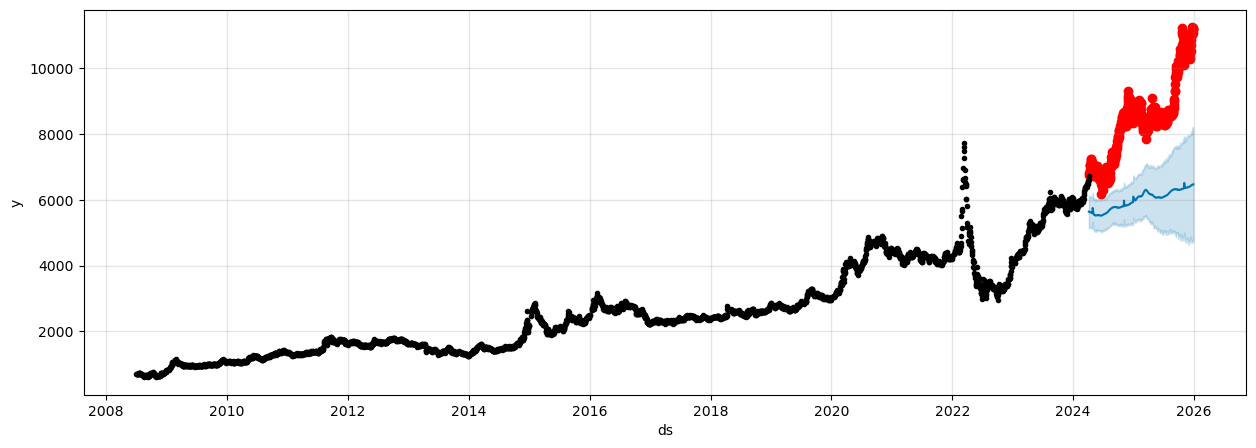

In [153]:
# ЗОЛОТО
fig, ax = plt.subplots(figsize=(15, 5))

ax.scatter(test_df_zoloto.ds, test_df_zoloto['y'], color='r') # фактические данные, красным цветом
fig = model1.plot(predict1, ax=ax)

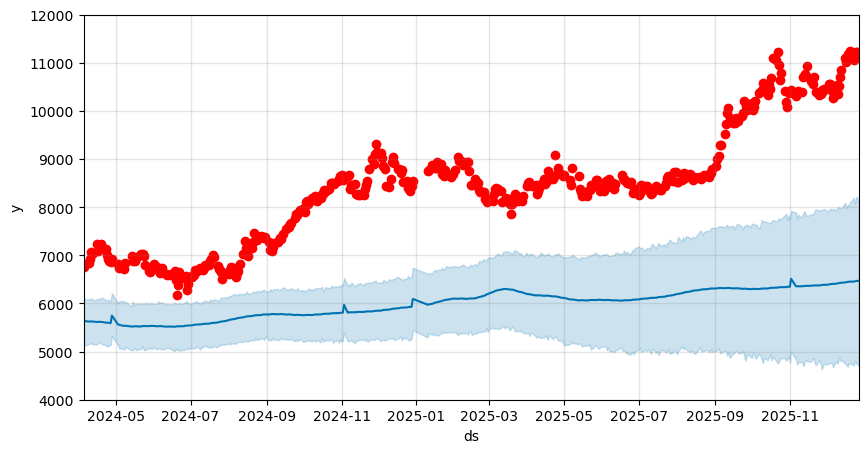

In [154]:
# приблизим
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(test_df_zoloto.ds, test_df_zoloto['y'], color='r') 
fig = model1.plot(predict1, ax=ax)
ax.set_xbound(lower=test_df_zoloto['ds'][:1].values[0],
              upper=test_df_zoloto['ds'][-1:].values[-1])
ax.set_ylim(4000, 12000)
plt.show()

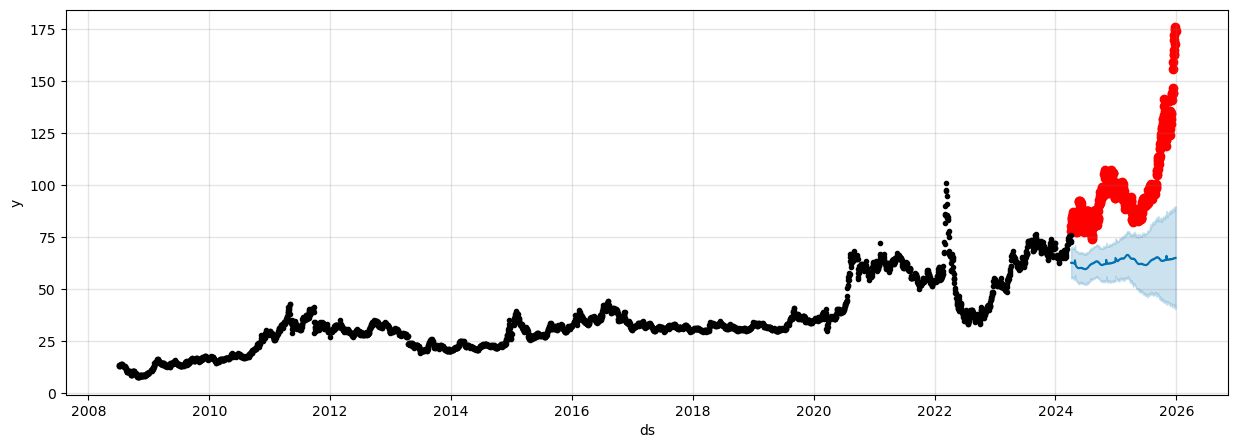

In [155]:
# СЕРЕБРО
fig, ax = plt.subplots(figsize=(15, 5))

ax.scatter(test_df_serebro.ds, test_df_serebro['y'], color='r') # фактические данные, красным цветом
fig = model2.plot(predict2, ax=ax)

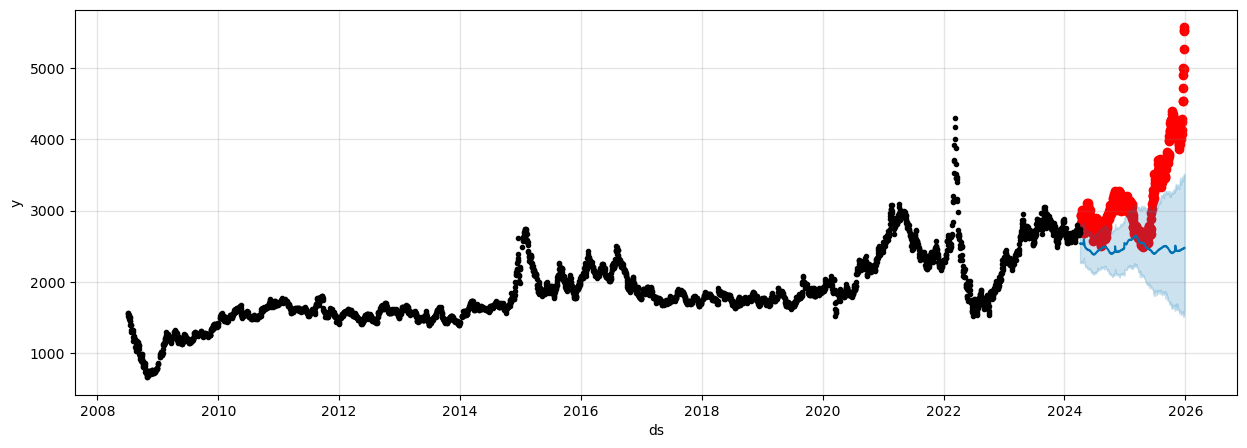

In [156]:
# ПЛАТИНА
fig, ax = plt.subplots(figsize=(15, 5))

ax.scatter(test_df_platina.ds, test_df_platina['y'], color='r') # фактические данные, красным цветом
fig = model3.plot(predict3, ax=ax)

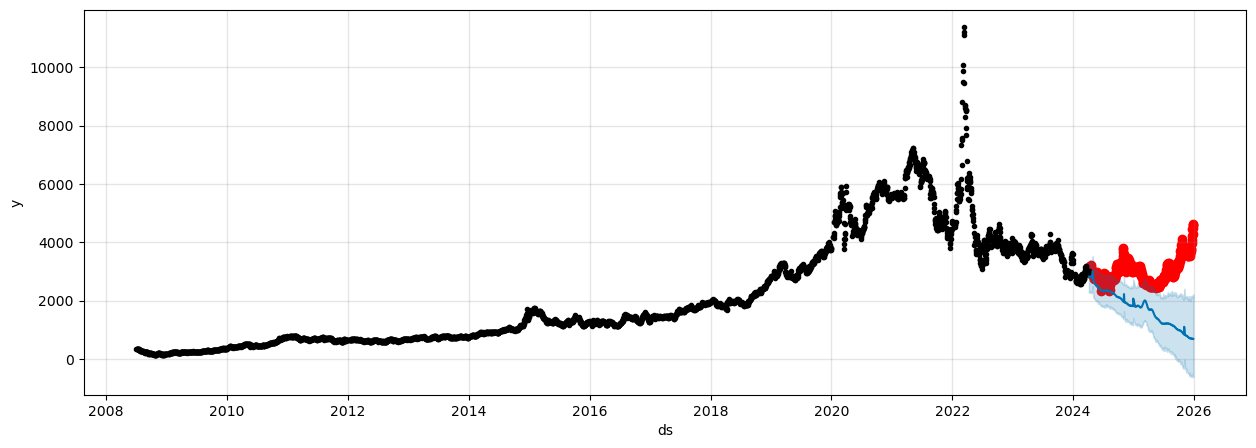

In [157]:
# ПАЛЛАДИЙ
fig, ax = plt.subplots(figsize=(15, 5))

ax.scatter(test_df_palladiy.ds, test_df_palladiy['y'], color='r') # фактические данные, красным цветом
fig = model4.plot(predict4, ax=ax)

## Оценим модель Prophet

In [179]:
# датасет для итогового предсказания
df_test_null_zoloto = test_df_zoloto.copy()
df_test_null_zoloto['y'] = None

df_predict_zoloto = pd.concat([train_df_zoloto, df_test_null_zoloto])
predict1 = model1.predict(df_predict_zoloto)

df_test_null_serebro = test_df_serebro.copy()
df_test_null_serebro['y'] = None

df_predict_serebro = pd.concat([train_df_serebro, df_test_null_serebro])
predict2 = model2.predict(df_predict_serebro)

df_test_null_platina = test_df_platina.copy()
df_test_null_platina['y'] = None

df_predict_platina = pd.concat([train_df_platina, df_test_null_platina])
predict3 = model3.predict(df_predict_platina)

df_test_null_palladiy = test_df_palladiy.copy()
df_test_null_palladiy['y'] = None

df_predict_palladiy = pd.concat([train_df_palladiy, df_test_null_palladiy])
predict4 = model4.predict(df_predict_palladiy)

In [180]:
print('Для золота: ', mean_absolute_error(y_true=test_df_zoloto['y'],
                    y_pred=predict1['yhat'][train_df_zoloto.shape[0]:]))

print('Для серебра: ', mean_absolute_error(y_true=test_df_serebro['y'],
                    y_pred=predict2['yhat'][train_df_serebro.shape[0]:]))

print('Для платины: ', mean_absolute_error(y_true=test_df_platina['y'],
                    y_pred=predict3['yhat'][train_df_platina.shape[0]:]))

print('Для палладия: ', mean_absolute_error(y_true=test_df_palladiy['y'],
                    y_pred=predict4['yhat'][train_df_palladiy.shape[0]:]))

Для золота:  2442.4720085360213
Для серебра:  35.79904988563574
Для платины:  711.0074810093508
Для палладия:  1305.631334767348


In [181]:
print('Для золота: ', mean_absolute_percentage_error(y_true=test_df_zoloto['y'],
                    y_pred=predict1['yhat'][train_df_zoloto.shape[0]:]))

print('Для серебра: ', mean_absolute_percentage_error(y_true=test_df_serebro['y'],
                    y_pred=predict2['yhat'][train_df_serebro.shape[0]:]))

print('Для платины: ', mean_absolute_percentage_error(y_true=test_df_platina['y'],
                    y_pred=predict3['yhat'][train_df_platina.shape[0]:]))

print('Для палладия: ', mean_absolute_percentage_error(y_true=test_df_palladiy['y'],
                    y_pred=predict4['yhat'][train_df_palladiy.shape[0]:]))

Для золота:  0.2790680758657299
Для серебра:  0.3437923867903512
Для платины:  0.20115192122360823
Для палладия:  0.41131379667609275


Для золота: учитывая практически монотонное возрастание цены на золото и график сравнения реальных данных и прогнозов, мы можем просто каждый прогноз увеличить на некоторую фиксированную величину и чуть подправить угол наклона. Так получим более точные прогнозы на цену золота. Так мы, конечно, подстраиваемся под данные, но опять же золото монотонно растет уже долгое время.

Для серебра: такую тактику, как с золотом использовать не можем, так как такой бурный скачок - это что-то новое для серебра. Не понятно, что будет дальше.

Для платины: модель дает не самые плохие прогнозы. К тому же вспоминаем, что тренд у платины почти всегда на том же уровне, поэтому можно с помощью сезонности, полученной моделью, понять какая будет цена на платину в какой-либо сезон.

Для палладия: ошибка очень уж большая, да и не понятно, как её скорректировать. 

In [182]:
print(predict1[3897:3898])
print(df[3897:3898])

             ds       trend   yhat_lower  yhat_upper  trend_lower  \
3897 2024-04-05  5563.71144  5157.078328  6133.77217   5563.71144   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
3897   5563.71144       76.229029             76.229029             76.229029   

         weekly  weekly_lower  weekly_upper     yearly  yearly_lower  \
3897 -21.979592    -21.979592    -21.979592  98.208621     98.208621   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
3897     98.208621                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
3897                         0.0  5639.940469  
           Дата  Золото  Серебро  Платина  Палладий
3897 2024-04-05  6766.8    77.89  2756.99   3000.34


In [183]:
predict1['yhat'] += (df[3897:3898]['Золото']-predict1[3897:3898]['yhat']).values[0]

print("Скорректированная оценка для золота:")

print(mean_absolute_error(y_true=test_df_zoloto['y'],
                    y_pred=predict1['yhat'][train_df_zoloto.shape[0]:]))

print(mean_absolute_percentage_error(y_true=test_df_zoloto['y'],
                               y_pred=predict1['yhat'][train_df_zoloto.shape[0]:]))

Скорректированная оценка для золота:
1334.2419917520804
0.14561246107967687


In [184]:
predict1['yhat'] *= 1.2

print("Скорректированная оценка для золота:")

print(mean_absolute_error(y_true=test_df_zoloto['y'],
                    y_pred=predict1['yhat'][train_df_zoloto.shape[0]:]))

print(mean_absolute_percentage_error(y_true=test_df_zoloto['y'],
                               y_pred=predict1['yhat'][train_df_zoloto.shape[0]:]))

Скорректированная оценка для золота:
741.7700243225302
0.09028204364408021


Видим, что прогнозы для золота стали намного лучше. 

## Прогноз на 2026 от Prophet

In [185]:
%%time
model_full_1 = Prophet(changepoint_prior_scale=0.3)
model_full_1.fit(df_zoloto)

model_full_2 = Prophet(changepoint_prior_scale=0.3)
model_full_2.fit(df_serebro)

model_full_3 = Prophet(changepoint_prior_scale=0.3)
model_full_3.fit(df_platina)

model_full_4 = Prophet(changepoint_prior_scale=0.3)
model_full_4.fit(df_palladiy)

04:59:56 - cmdstanpy - INFO - Chain [1] start processing
05:00:03 - cmdstanpy - INFO - Chain [1] done processing
05:00:04 - cmdstanpy - INFO - Chain [1] start processing
05:00:06 - cmdstanpy - INFO - Chain [1] done processing
05:00:07 - cmdstanpy - INFO - Chain [1] start processing
05:00:09 - cmdstanpy - INFO - Chain [1] done processing
05:00:10 - cmdstanpy - INFO - Chain [1] start processing
05:00:12 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 3.86 s
Wall time: 16 s


In [186]:
# датафрейм на 300 дней вперед с дневной частотой
future1 = model_full_1.make_future_dataframe(periods=300, freq='D')
forecast1 = model_full_1.predict(future1)
"""
Здесь также подкорректируем прогнозы
"""
cor = (df[3897:3898]['Золото']-predict1[3897:3898]['yhat']).values[0]
forecast1['yhat'] = 1.2*(forecast1['yhat']+cor)
forecast1['yhat_lower'] = 1.2*(forecast1['yhat_lower']+cor)
forecast1['yhat_upper'] = 1.2*(forecast1['yhat_upper']+cor)

future2 = model_full_2.make_future_dataframe(periods=300, freq='D')
forecast2 = model_full_2.predict(future2)

future3 = model_full_3.make_future_dataframe(periods=300, freq='D')
forecast3 = model_full_3.predict(future3)

future4 = model_full_4.make_future_dataframe(periods=300, freq='D')
forecast4 = model_full_4.predict(future4)

In [187]:
forecast1[df.shape[0]:][:8]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
4330,2025-12-28,10160.913821,10302.917779,11228.433296,10160.913821,10160.913821,168.001696,168.001696,168.001696,190.023744,190.023744,190.023744,-22.022048,-22.022048,-22.022048,0.0,0.0,0.0,10770.666619
4331,2025-12-29,10166.299745,10052.507137,11004.107459,10166.299745,10166.299745,-26.957179,-26.957179,-26.957179,-1.900331,-1.900331,-1.900331,-25.056849,-25.056849,-25.056849,0.0,0.0,0.0,10543.179078
4332,2025-12-30,10171.685669,9979.120764,11001.924089,10171.685669,10171.685669,-72.005530,-72.005530,-72.005530,-43.918825,-43.918825,-43.918825,-28.086704,-28.086704,-28.086704,0.0,0.0,0.0,10495.584167
4333,2025-12-31,10177.071593,10014.952658,10963.702604,10177.071593,10177.071593,-75.043513,-75.043513,-75.043513,-44.009214,-44.009214,-44.009214,-31.034299,-31.034299,-31.034299,0.0,0.0,0.0,10498.401695
4334,2026-01-01,10182.457517,10078.231185,11014.581876,10182.457517,10182.457517,-68.122516,-68.122516,-68.122516,-34.302558,-34.302558,-34.302558,-33.819958,-33.819958,-33.819958,0.0,0.0,0.0,10513.170001
4335,2026-01-02,10187.843441,10065.755115,10991.801711,10187.843441,10187.843441,-69.651681,-69.651681,-69.651681,-33.288199,-33.288199,-33.288199,-36.363482,-36.363482,-36.363482,0.0,0.0,0.0,10517.798111
4336,2026-01-03,10193.229365,10034.529481,10985.592472,10193.229365,10193.229365,-71.190693,-71.190693,-71.190693,-32.604616,-32.604616,-32.604616,-38.586077,-38.586077,-38.586077,0.0,0.0,0.0,10522.414407
4337,2026-01-04,10198.615289,10301.683902,11284.076763,10198.615289,10198.615289,149.611419,149.611419,149.611419,190.023744,190.023744,190.023744,-40.412325,-40.412325,-40.412325,0.0,0.0,0.0,10793.840049


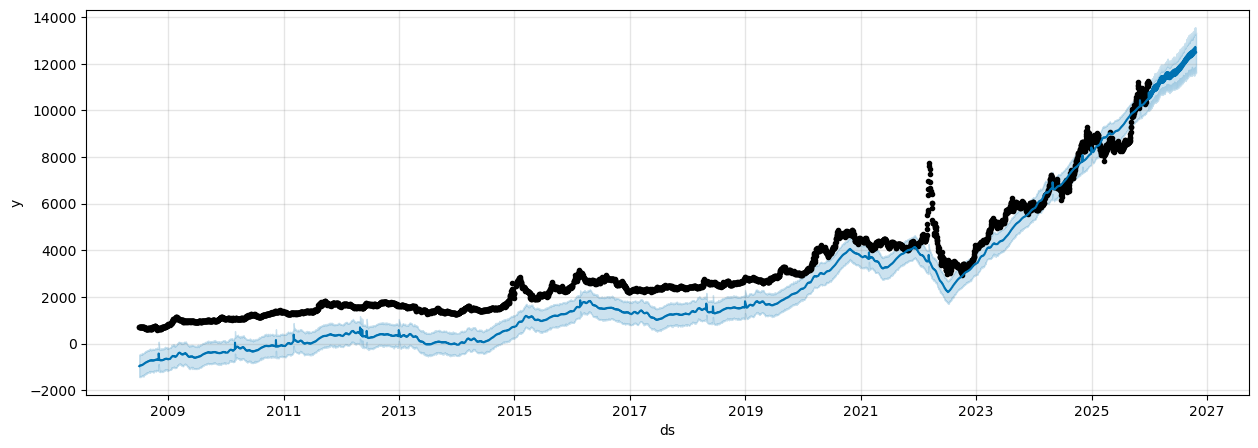

In [188]:
fig, ax = plt.subplots(figsize=(15, 5))
fig = model_full_1.plot(forecast1, ax=ax)

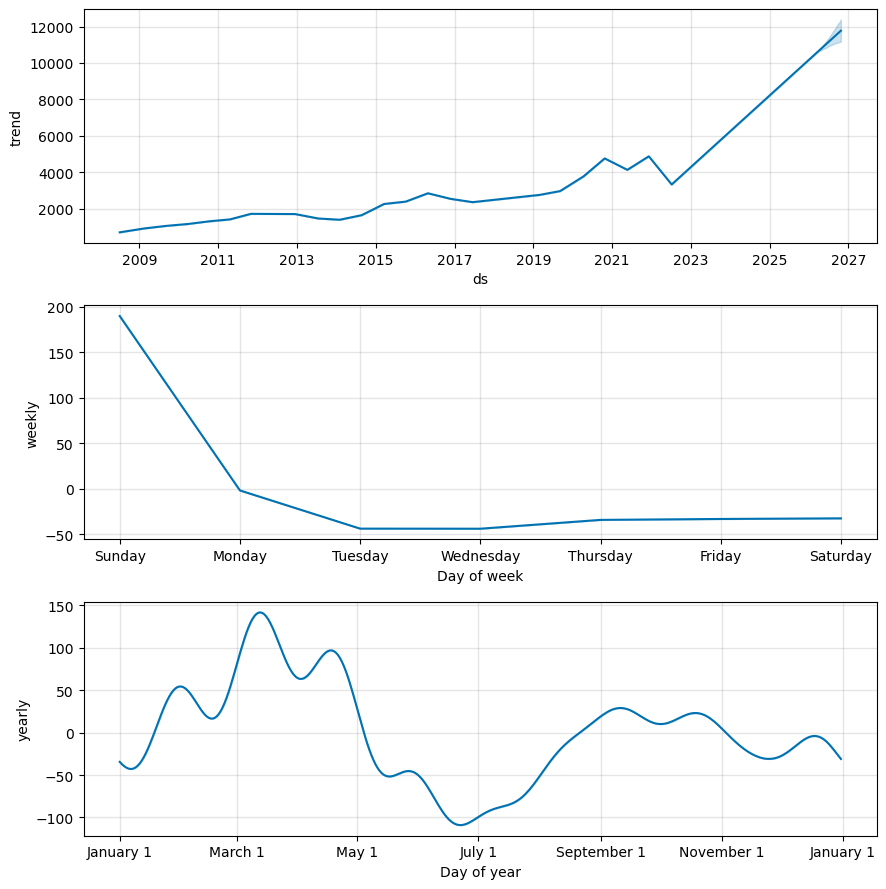

In [189]:
fig = model_full_1.plot_components(forecast1)
plt.show()

## **NeuralProphet** 

“улучшенная” версия Prophet, разработанной с привлечением нейросетевых методов.

Построена на базе PyTorch, что позволяет использовать глубокое обучение для выявления более сложных и нелинейных паттернов в данных.

In [28]:
'''
!pip install --upgrade numba
!pip install --upgrade numpy==1.26.4
!pip install --upgrade bokeh>=1.0.0
!pip install neuralprophet
'''

'\n!pip install --upgrade numba\n!pip install --upgrade numpy==1.26.4\n!pip install --upgrade bokeh>=1.0.0\n!pip install neuralprophet\n'

In [29]:
'''
# Обновить pip и setuptools для корректной установки пакетов
!pip install --upgrade pip setuptools

# Установить или обновить bottleneck до версии 1.3.6 или выше
!pip install --upgrade bottleneck>=1.3.6

# Переустановить plotly для корректной работы интерактивных графиков
!pip install --upgrade plotly
'''

'\n# Обновить pip и setuptools для корректной установки пакетов\n!pip install --upgrade pip setuptools\n\n# Установить или обновить bottleneck до версии 1.3.6 или выше\n!pip install --upgrade bottleneck>=1.3.6\n\n# Переустановить plotly для корректной работы интерактивных графиков\n!pip install --upgrade plotly\n'

In [190]:
from neuralprophet import NeuralProphet

In [191]:
m1_1 = NeuralProphet()
metrics1_1 = m1_1.fit(train_df_zoloto, freq="D", epochs=100)

m1_2 = NeuralProphet()
metrics1_2 = m1_2.fit(train_df_serebro, freq="D", epochs=100)

m1_3 = NeuralProphet()
metrics1_3 = m1_3.fit(train_df_platina, freq="D", epochs=100)

m1_4 = NeuralProphet()
metrics1_4 = m1_4.fit(train_df_palladiy, freq="D", epochs=100)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.152% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (61) is too small than the required number                     for the learning rate finder (240). The results might not be optimal.


Finding best initial lr:   0%|          | 0/240 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.152% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (61) is too small than the required number                     for the learning rate finder (240). The results might not be optimal.


Finding best initial lr:   0%|          | 0/240 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.152% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (61) is too small than the required number                     for the learning rate finder (240). The results might not be optimal.


Finding best initial lr:   0%|          | 0/240 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.152% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (61) is too small than the required number                     for the learning rate finder (240). The results might not be optimal.


Finding best initial lr:   0%|          | 0/240 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

In [192]:
m2_1 = NeuralProphet()
metrics2_1 = m2_1.fit(train_df_zoloto, freq="D", epochs=70)

m2_2 = NeuralProphet()
metrics2_2 = m2_2.fit(train_df_serebro, freq="D", epochs=70)

m2_3 = NeuralProphet()
metrics2_3 = m2_3.fit(train_df_platina, freq="D", epochs=70)

m2_4 = NeuralProphet()
metrics2_4 = m2_4.fit(train_df_palladiy, freq="D", epochs=70)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.152% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (61) is too small than the required number                     for the learning rate finder (240). The results might not be optimal.


Finding best initial lr:   0%|          | 0/240 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.152% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (61) is too small than the required number                     for the learning rate finder (240). The results might not be optimal.


Finding best initial lr:   0%|          | 0/240 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.152% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (61) is too small than the required number                     for the learning rate finder (240). The results might not be optimal.


Finding best initial lr:   0%|          | 0/240 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.152% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (61) is too small than the required number                     for the learning rate finder (240). The results might not be optimal.


Finding best initial lr:   0%|          | 0/240 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

In [193]:
m3_1 = NeuralProphet()
metrics3_1 = m3_1.fit(train_df_zoloto, freq="D", epochs=40)

m3_2 = NeuralProphet()
metrics3_2 = m3_2.fit(train_df_serebro, freq="D", epochs=40)

m3_3 = NeuralProphet()
metrics3_3 = m3_3.fit(train_df_platina, freq="D", epochs=40)

m3_4 = NeuralProphet()
metrics3_4 = m3_4.fit(train_df_palladiy, freq="D", epochs=40)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.152% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (61) is too small than the required number                     for the learning rate finder (240). The results might not be optimal.


Finding best initial lr:   0%|          | 0/240 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.152% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (61) is too small than the required number                     for the learning rate finder (240). The results might not be optimal.


Finding best initial lr:   0%|          | 0/240 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.152% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (61) is too small than the required number                     for the learning rate finder (240). The results might not be optimal.


Finding best initial lr:   0%|          | 0/240 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.152% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (61) is too small than the required number                     for the learning rate finder (240). The results might not be optimal.


Finding best initial lr:   0%|          | 0/240 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

In [194]:
predict_neurop1_1 = m1_1.predict(df_predict_zoloto)
predict_neurop1_2 = m1_2.predict(df_predict_serebro)
predict_neurop1_3 = m1_3.predict(df_predict_platina)
predict_neurop1_4 = m1_3.predict(df_predict_palladiy)

predict_neurop2_1 = m2_1.predict(df_predict_zoloto)
predict_neurop2_2 = m2_2.predict(df_predict_serebro)
predict_neurop2_3 = m2_3.predict(df_predict_platina)
predict_neurop2_4 = m2_3.predict(df_predict_palladiy)

predict_neurop3_1 = m3_1.predict(df_predict_zoloto)
predict_neurop3_2 = m3_2.predict(df_predict_serebro)
predict_neurop3_3 = m3_3.predict(df_predict_platina)
predict_neurop3_4 = m3_3.predict(df_predict_palladiy)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 433 rows at the end with NaNs in 'y' column.


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 433 rows at the end with NaNs in 'y' column.


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 433 rows at the end with NaNs in 'y' column.


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 433 rows at the end with NaNs in 'y' column.


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 433 rows at the end with NaNs in 'y' column.


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 433 rows at the end with NaNs in 'y' column.


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 433 rows at the end with NaNs in 'y' column.


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 433 rows at the end with NaNs in 'y' column.


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 433 rows at the end with NaNs in 'y' column.


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 433 rows at the end with NaNs in 'y' column.


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 433 rows at the end with NaNs in 'y' column.


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.252% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 433 rows at the end with NaNs in 'y' column.


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [34]:
#!pip install plotly-resampler

In [37]:
#!pip install anywidget

In [195]:
print('Для золота:')
print('при 100 эпохах:', mean_absolute_error(y_true=test_df_zoloto['y'],
                    y_pred=predict_neurop1_1['yhat1'][train_df_zoloto.shape[0]:]))
print('при 70 эпохах:', mean_absolute_error(y_true=test_df_zoloto['y'],
                    y_pred=predict_neurop2_1['yhat1'][train_df_zoloto.shape[0]:]))
print('при 40 эпохах:', mean_absolute_error(y_true=test_df_zoloto['y'],
                    y_pred=predict_neurop3_1['yhat1'][train_df_zoloto.shape[0]:]))
print('')

print('Для серебра:')
print('при 100 эпохах:', mean_absolute_error(y_true=test_df_serebro['y'],
                    y_pred=predict_neurop1_2['yhat1'][train_df_serebro.shape[0]:]))
print('при 70 эпохах:', mean_absolute_error(y_true=test_df_serebro['y'],
                    y_pred=predict_neurop2_2['yhat1'][train_df_serebro.shape[0]:]))
print('при 40 эпохах:', mean_absolute_error(y_true=test_df_serebro['y'],
                    y_pred=predict_neurop3_2['yhat1'][train_df_serebro.shape[0]:]))
print('')

print('Для платины:')
print('при 100 эпохах:', mean_absolute_error(y_true=test_df_platina['y'],
                    y_pred=predict_neurop1_3['yhat1'][train_df_platina.shape[0]:]))
print('при 70 эпохах:', mean_absolute_error(y_true=test_df_platina['y'],
                    y_pred=predict_neurop2_3['yhat1'][train_df_platina.shape[0]:]))
print('при 40 эпохах:', mean_absolute_error(y_true=test_df_platina['y'],
                    y_pred=predict_neurop3_3['yhat1'][train_df_platina.shape[0]:]))
print('')

print('Для палладия:')
print('при 100 эпохах:', mean_absolute_error(y_true=test_df_palladiy['y'],
                    y_pred=predict_neurop1_4['yhat1'][train_df_palladiy.shape[0]:]))
print('при 70 эпохах:', mean_absolute_error(y_true=test_df_palladiy['y'],
                    y_pred=predict_neurop2_4['yhat1'][train_df_palladiy.shape[0]:]))
print('при 40 эпохах:', mean_absolute_error(y_true=test_df_palladiy['y'],
                    y_pred=predict_neurop3_4['yhat1'][train_df_palladiy.shape[0]:]))
print('')

Для золота:
при 100 эпохах: 2603.1218040920903
при 70 эпохах: 2601.7697296297633
при 40 эпохах: 2570.53056428623

Для серебра:
при 100 эпохах: 28.143662740870383
при 70 эпохах: 28.009968948892855
при 40 эпохах: 27.332286746265158

Для платины:
при 100 эпохах: 503.1447597160075
при 70 эпохах: 501.3248882704244
при 40 эпохах: 491.74844149195286

Для палладия:
при 100 эпохах: 375.7304409190964
при 70 эпохах: 374.2332630719544
при 40 эпохах: 366.5988992358906



In [196]:
print('Для золота:')
print('при 100 эпохах:', mean_absolute_percentage_error(y_true=test_df_zoloto['y'],
                    y_pred=predict_neurop1_1['yhat1'][train_df_zoloto.shape[0]:]))
print('при 70 эпохах:', mean_absolute_percentage_error(y_true=test_df_zoloto['y'],
                    y_pred=predict_neurop2_1['yhat1'][train_df_zoloto.shape[0]:]))
print('при 40 эпохах:', mean_absolute_percentage_error(y_true=test_df_zoloto['y'],
                    y_pred=predict_neurop3_1['yhat1'][train_df_zoloto.shape[0]:]))
print('')

print('Для серебра:')
print('при 100 эпохах:', mean_absolute_percentage_error(y_true=test_df_serebro['y'],
                    y_pred=predict_neurop1_2['yhat1'][train_df_serebro.shape[0]:]))
print('при 70 эпохах:', mean_absolute_percentage_error(y_true=test_df_serebro['y'],
                    y_pred=predict_neurop2_2['yhat1'][train_df_serebro.shape[0]:]))
print('при 40 эпохах:', mean_absolute_percentage_error(y_true=test_df_serebro['y'],
                    y_pred=predict_neurop3_2['yhat1'][train_df_serebro.shape[0]:]))
print('')

print('Для платины:')
print('при 100 эпохах:', mean_absolute_percentage_error(y_true=test_df_platina['y'],
                    y_pred=predict_neurop1_3['yhat1'][train_df_platina.shape[0]:]))
print('при 70 эпохах:', mean_absolute_percentage_error(y_true=test_df_platina['y'],
                    y_pred=predict_neurop2_3['yhat1'][train_df_platina.shape[0]:]))
print('при 40 эпохах:', mean_absolute_percentage_error(y_true=test_df_platina['y'],
                    y_pred=predict_neurop3_3['yhat1'][train_df_platina.shape[0]:]))
print('')

print('Для палладия:')
print('при 100 эпохах:', mean_absolute_percentage_error(y_true=test_df_palladiy['y'],
                    y_pred=predict_neurop1_4['yhat1'][train_df_palladiy.shape[0]:]))
print('при 70 эпохах:', mean_absolute_percentage_error(y_true=test_df_palladiy['y'],
                    y_pred=predict_neurop2_4['yhat1'][train_df_palladiy.shape[0]:]))
print('при 40 эпохах:', mean_absolute_percentage_error(y_true=test_df_palladiy['y'],
                    y_pred=predict_neurop3_4['yhat1'][train_df_palladiy.shape[0]:]))
print('')

Для золота:
при 100 эпохах: 0.29768117087373824
при 70 эпохах: 0.29750998607050927
при 40 эпохах: 0.29379119237505635

Для серебра:
при 100 эпохах: 0.26565624900097295
при 70 эпохах: 0.2643982669746135
при 40 эпохах: 0.2574918053081034

Для платины:
при 100 эпохах: 0.1404287508922803
при 70 эпохах: 0.1398879152213793
при 40 эпохах: 0.13737150194703415

Для палладия:
при 100 эпохах: 0.11526004775330938
при 70 эпохах: 0.11478839770747438
при 40 эпохах: 0.11279096465192719



Видим, что Neural Prophet относительно золота справилась хуже с поставленной задачей, чем обычная модель Prophet, которая изначально выдавала ошибку чуть менее 28%, а с нашей доработкой смогла выдавать ошибку лишь 9%. Поэтому для золота оставим обычную модель.

Для остальных драгметаллов Neural Prophet делает прогнозы намного лучше, чем обычная модель, поэтому возьмем её.

# Прогноз на 2026

Для золота:

In [197]:
forecast1[['ds', 'yhat']].iloc[-296:,:]

,ds,yhat
4334,2026-01-01,10513.170001
4335,2026-01-02,10517.798111
4336,2026-01-03,10522.414407
4337,2026-01-04,10793.840049
4338,2026-01-05,10568.362464
...,...,...
4625,2026-10-19,12501.176826
4626,2026-10-20,12457.029726
4627,2026-10-21,12462.914450
4628,2026-10-22,12480.271700


Для остальных металлов:

In [237]:
future = pd.DataFrame({
    'ds': pd.date_range('2026-01-01', periods=300, freq='D'), 'y': float('nan')
})
pred2 = m2_2.predict(future)
print(pred2)

pred3 = m3_3.predict(future)

pred4 = m3_4.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


            ds   y       yhat1      trend  season_yearly  season_weekly
0   2026-01-01 NaN   75.332771  48.415081      -0.336084      27.253777
1   2026-01-02 NaN   75.344765  48.429497      -0.307872      27.223141
2   2026-01-03 NaN   75.510941  48.443913      -0.279488      27.346521
3   2026-01-04 NaN   79.459160  48.458313      -0.250833      31.251690
4   2026-01-05 NaN -118.811172  48.472729      -0.222122    -167.061768
..         ...  ..         ...        ...            ...            ...
295 2026-10-23 NaN   79.134476  52.666084      -0.678495      27.146889
296 2026-10-24 NaN   79.275276  52.680492      -0.676691      27.271484
297 2026-10-25 NaN   83.199150  52.694901      -0.673767      31.178017
298 2026-10-26 NaN -115.017891  52.709309      -0.670105    -167.057083
299 2026-10-27 NaN   79.143204  52.723717      -0.665817      27.085306

[300 rows x 6 columns]


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


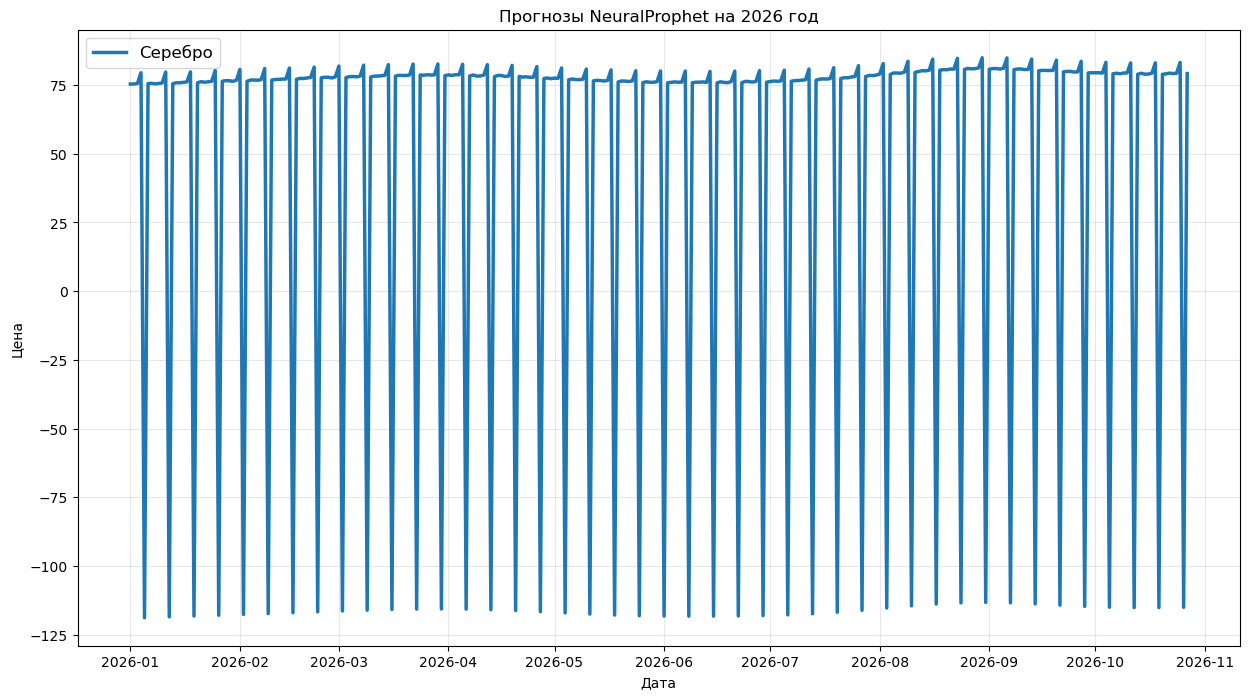

In [238]:
plt.figure(figsize=(15, 8))
plt.plot(pred2['ds'], pred2['yhat1'], label='Серебро', linewidth=2.5)
plt.title('Прогнозы NeuralProphet на 2026 год')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

Напомню, что мы убирали понедельник, однако в прогнозах он все еще есть. Отсюда и выбросы. Уберем понедельник.

In [239]:
pred2['ds'] = pd.to_datetime(pred2['ds'])
pred2_fix = pred2[pred2['ds'].dt.weekday != 0]
pred3['ds'] = pd.to_datetime(pred3['ds'])
pred3_fix = pred3[pred3['ds'].dt.weekday != 0]
pred4['ds'] = pd.to_datetime(pred4['ds'])
pred4_fix = pred4[pred4['ds'].dt.weekday != 0]

In [240]:
pred2_fix[-300:]

,ds,y,yhat1,trend,season_yearly,season_weekly
0,2026-01-01,NaN,75.332771,48.415081,-0.336084,27.253777
1,2026-01-02,NaN,75.344765,48.429497,-0.307872,27.223141
2,2026-01-03,NaN,75.510941,48.443913,-0.279488,27.346521
3,2026-01-04,NaN,79.459160,48.458313,-0.250833,31.251690
5,2026-01-06,NaN,75.506157,48.487144,-0.193129,27.212147
...,...,...,...,...,...,...
294,2026-10-22,NaN,79.302010,52.651669,-0.679233,27.329580
295,2026-10-23,NaN,79.134476,52.666084,-0.678495,27.146889
296,2026-10-24,NaN,79.275276,52.680492,-0.676691,27.271484
297,2026-10-25,NaN,83.199150,52.694901,-0.673767,31.178017


Серебро:

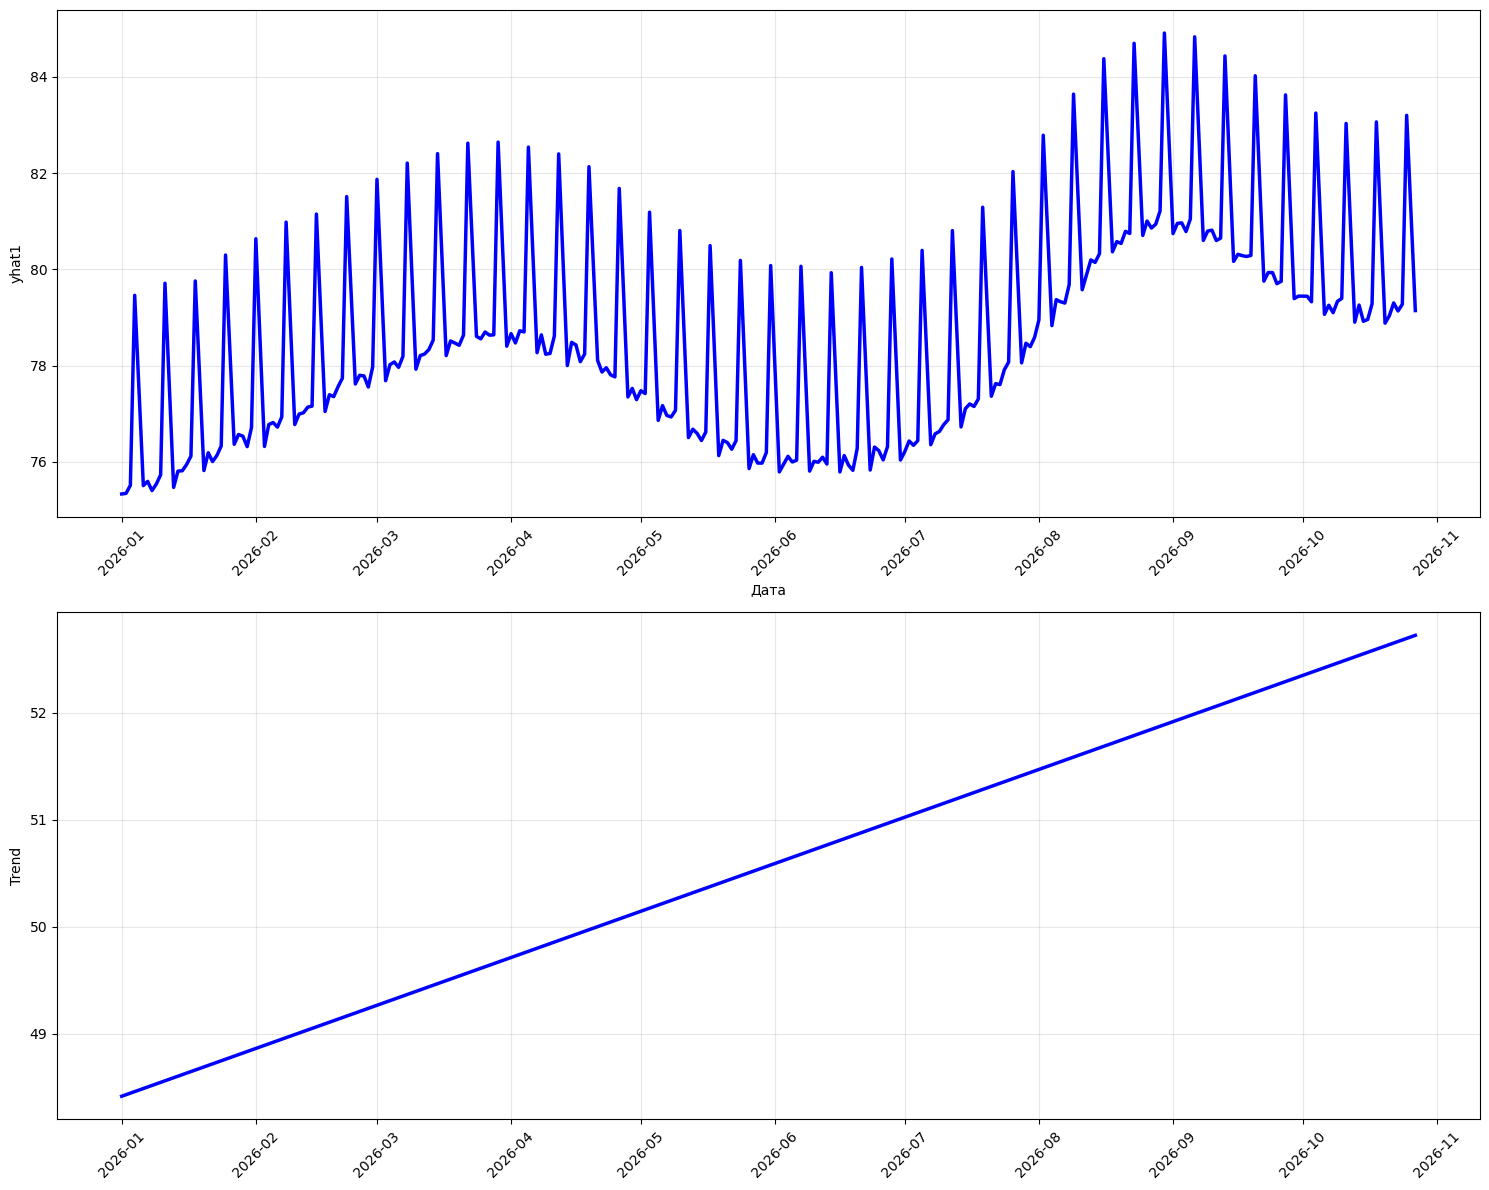

In [247]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# График 1: yhat1
ax1.plot(pred2_fix['ds'], pred2_fix['yhat1'], 'b-', linewidth=2.5)
ax1.set_xlabel('Дата')
ax1.set_ylabel('yhat1')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# График 2: trend
ax2.plot(pred2_fix['ds'], pred2_fix['trend'], 'b-', linewidth=2.5)
ax2.set_ylabel('Trend')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Платина:

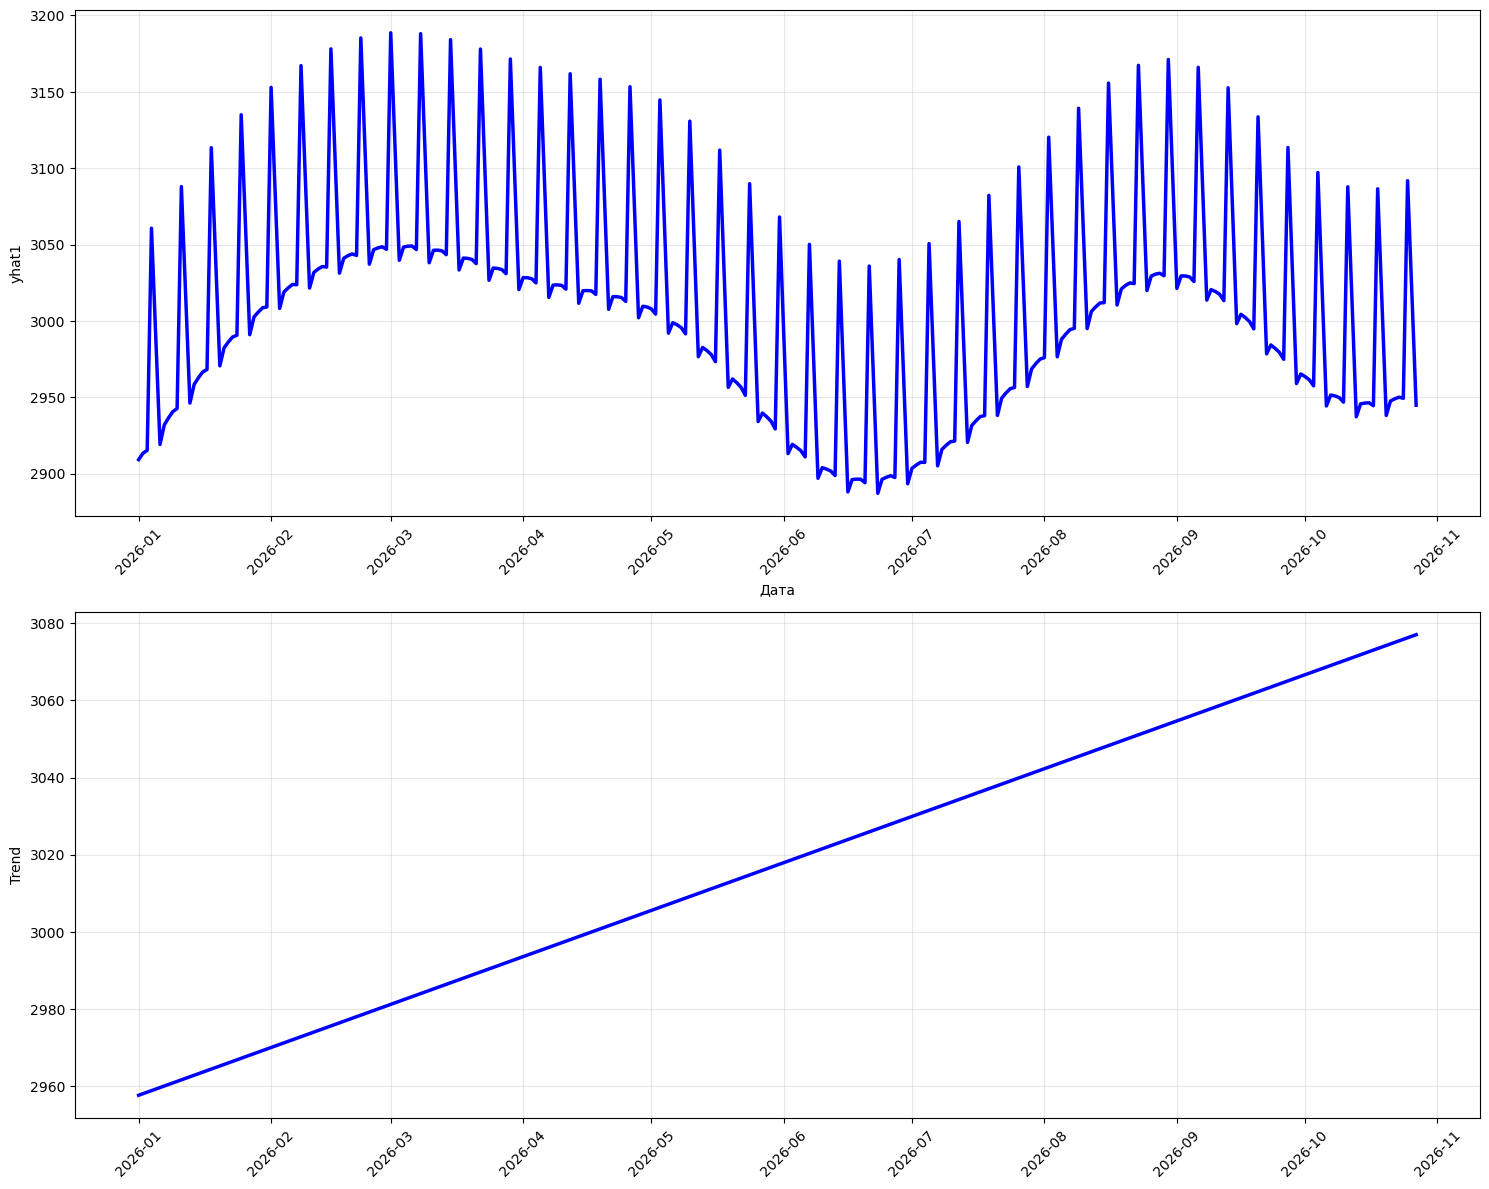

In [248]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# График 1: yhat1
ax1.plot(pred3_fix['ds'], pred3_fix['yhat1'], 'b-', linewidth=2.5)
ax1.set_xlabel('Дата')
ax1.set_ylabel('yhat1')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# График 2: trend
ax2.plot(pred3_fix['ds'], pred3_fix['trend'], 'b-', linewidth=2.5)
ax2.set_ylabel('Trend')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Палладий:

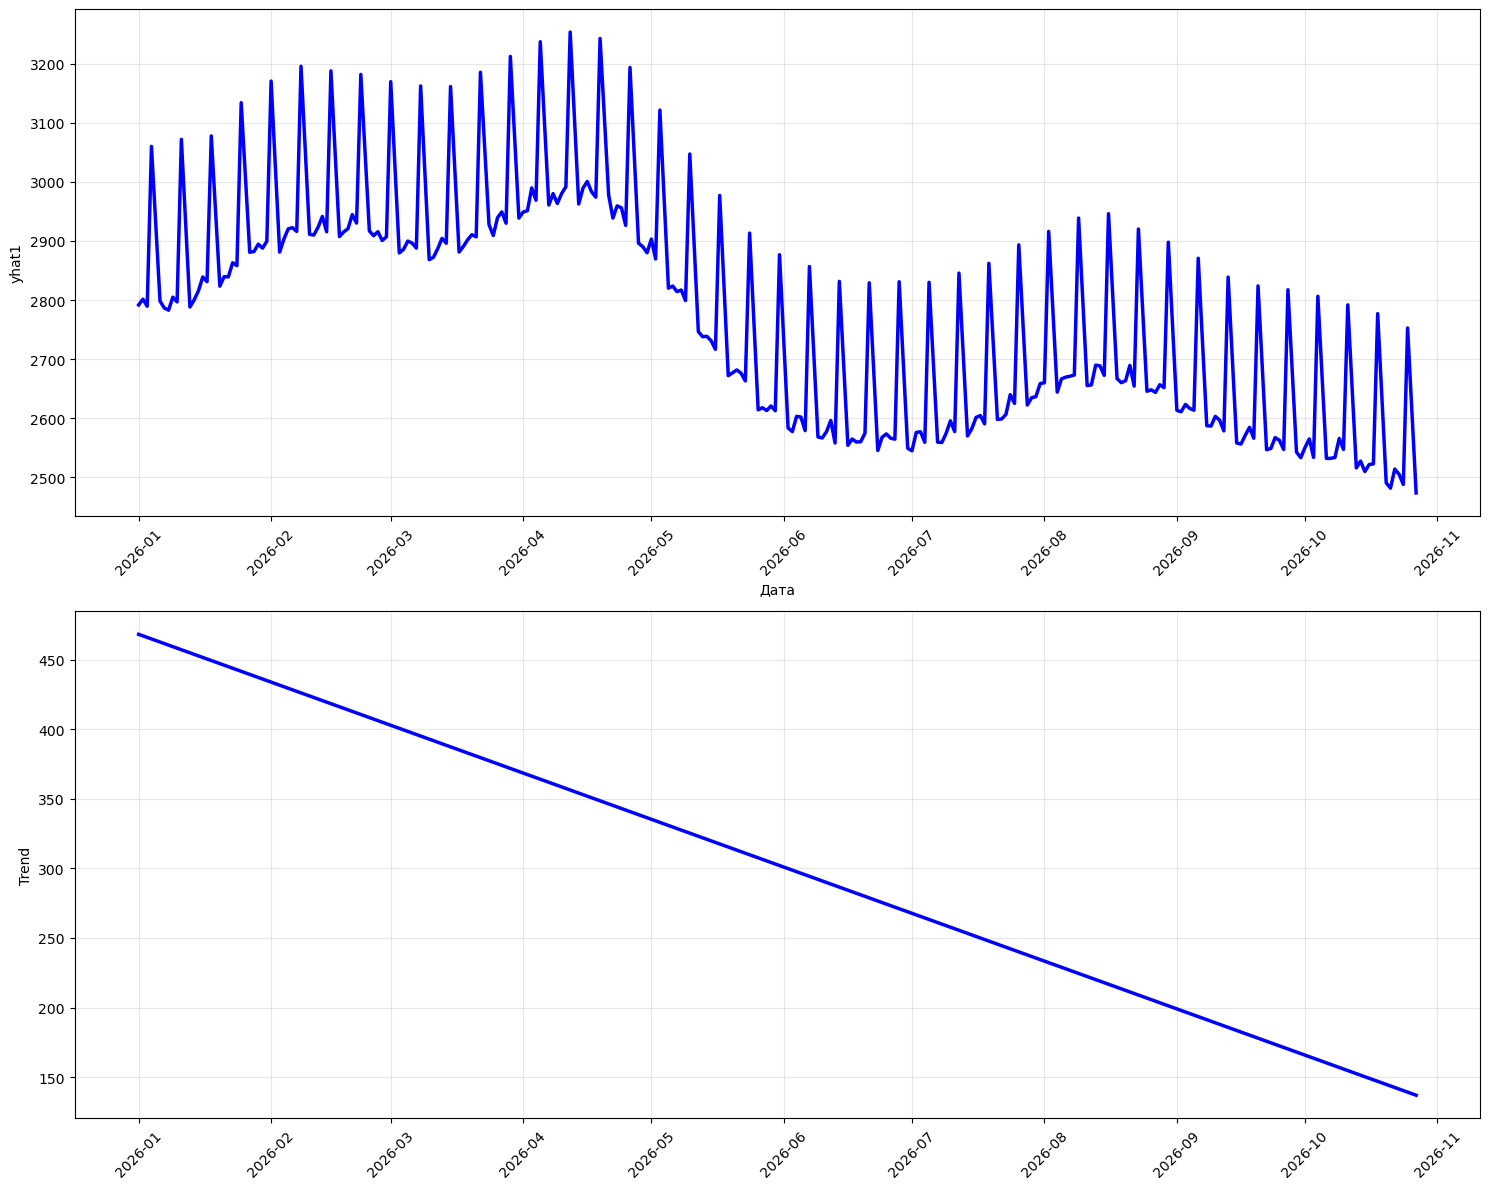

In [249]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# График 1: yhat1
ax1.plot(pred4_fix['ds'], pred4_fix['yhat1'], 'b-', linewidth=2.5)
ax1.set_xlabel('Дата')
ax1.set_ylabel('yhat1')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# График 2: trend
ax2.plot(pred4_fix['ds'], pred4_fix['trend'], 'b-', linewidth=2.5)
ax2.set_ylabel('Trend')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Выводы по прогнозам драгоценных металлов:**
   - Палладий демонстрирует устойчивый нисходящий тренд — инвестиции в него нецелесообразны.

   - Серебро и платина имеют слабую восходящую динамику, однако прирост цен наврядли превысит инфляцию, что делает их доходность нулевой или отрицательной.

   - Золото выделяется стабильным и уверенным ростом, который сохраняется на протяжении многих лет и превышает инфляционные ожидания.

Таким образом, единственным перспективным активом для инвестиций в 2026 году является золото с горизонтом вложений 3+ года. Остальные драгоценные металлы не оправдывают вложений в текущих рыночных условиях.